# Model is Overfitting

## Key Issues Observed:

* Training loss is decreasing (from 138.5 to 2.1) but validation loss is increasing (from 4.6 to 14.7) - this is a clear sign of overfitting
* Very low accuracy values (around 0.0002 for training and 0 for validation)
* Increasing gap between training and validation RMSE

## Suggestive Measures:

1. **Regularization Techniques:**
* Add dropout layers (start with 0.2-0.3)
* Add L1/L2 regularization to your layers
* Try batch normalization

2. **Data Preprocessing:**
* Normalize/standardize your input data
* Check for and handle outliers
* Ensure proper train/validation split methodology for time series (maintain temporal order)
* Consider differencing or detrending if your data has strong trends

3. **Model Architecture:**
* Reduce model complexity if you have a deep network
* If using LSTM/GRU, adjust the number of units
* Try simpler architectures first (fewer layers)
* Consider adding skip connections

4. **Training Process:**
* Implement early stopping (your model starts overfitting after epoch 4)
* Reduce learning rate (try using learning rate scheduler)
* Experiment with different batch sizes
* Use K-fold cross-validation adapted for time series

5. **Feature Engineering:**
* Add relevant lag features
* Include domain-specific features
* Consider adding cyclical encodings for seasonal data
* Create rolling statistics features

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0 Data Ingestion

In [2]:
df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
df = df.drop(columns=['hour', 'day', 'month', 'year'])

df1 = df.copy()
df1.index = pd.to_datetime(df1['time'], format='%Y-%m-%d %H:%M:%S')
df1

time  temperature_2m  \
time                                                       
2000-01-01 00:00:00  2000-01-01 00:00:00             4.0   
2000-01-01 01:00:00  2000-01-01 01:00:00             4.1   
2000-01-01 02:00:00  2000-01-01 02:00:00             4.0   
2000-01-01 03:00:00  2000-01-01 03:00:00             6.5   
2000-01-01 04:00:00  2000-01-01 04:00:00            12.9   
...                                  ...             ...   
2024-12-31 19:00:00  2024-12-31 19:00:00             8.4   
2024-12-31 20:00:00  2024-12-31 20:00:00             8.4   
2024-12-31 21:00:00  2024-12-31 21:00:00             8.4   
2024-12-31 22:00:00  2024-12-31 22:00:00             8.9   
2024-12-31 23:00:00  2024-12-31 23:00:00             8.1   

                     relative_humidity_2m  dew_point_2m  rain  \
time                                                            
2000-01-01 00:00:00                    96           3.3   0.0   
2000-01-01 01:00:00                    95           3.3   0.0   
2000-01-01 02:00:00                    95           3.2   0.0   
2000-01-01 03:00:00                    92           5.3   0.0   
2000-01-01 04:00:00                    75           8.6   0.0   
...                                   ...           ...   ...   
2024-12-31 19:00:00                    97           7.9   0.0   
2024-12-31 20:00:00                    96           7.8   0.0   
2024-12-31 21:00:00                    91           7.1   0.0   
2024-12-31 22:00:00                    80           5.7   0.0   
2024-12-31 23:00:00                    79           4.6   0.0   

                     cloud_cover_low  cloud_cover_mid  \
time                                                    
2000-01-01 00:00:00                0                0   
2000-01-01 01:00:00                0                1   
2000-01-01 02:00:00                0                1   
2000-01-01 03:00:00                0                3   
2000-01-01 04:00:00                0                0   
...                              ...              ...   
2024-12-31 19:00:00              100                5   
2024-12-31 20:00:00               95               34   
2024-12-31 21:00:00               57               54   
2024-12-31 22:00:00               43                7   
2024-12-31 23:00:00               37                7   

                     et0_fao_evapotranspiration  vapour_pressure_deficit  \
time                                                                       
2000-01-01 00:00:00                        0.00                     0.04   
2000-01-01 01:00:00                        0.00                     0.04   
2000-01-01 02:00:00                        0.01                     0.04   
2000-01-01 03:00:00                        0.02                     0.07   
2000-01-01 04:00:00                        0.13                     0.37   
...                                         ...                      ...   
2024-12-31 19:00:00                        0.00                     0.03   
2024-12-31 20:00:00                        0.00                     0.04   
2024-12-31 21:00:00                        0.00                     0.10   
2024-12-31 22:00:00                        0.00                     0.23   
2024-12-31 23:00:00                        0.00                     0.23   

                     wind_speed_10m  wind_speed_100m  wind_gusts_10m  
time                                                                  
2000-01-01 00:00:00             3.8              3.6            11.5  
2000-01-01 01:00:00             4.1              4.4            11.9  
2000-01-01 02:00:00             3.8              4.5            11.9  
2000-01-01 03:00:00             4.3              4.0            13.0  
2000-01-01 04:00:00             2.0              2.5            13.0  
...                             ...              ...             ...  
2024-12-31 19:00:00             1.5              3.1             4.0  
2024-12-31 20:00:00             2.7    

In [3]:
rain = df1['rain']
rain_df = pd.DataFrame({'Rain': rain})

rain_df[rain_df['Rain'] != 0]['Rain']

time
2000-01-09 04:00:00    0.1
2000-01-11 02:00:00    0.2
2000-01-11 03:00:00    0.3
2000-01-12 04:00:00    0.2
2000-01-12 05:00:00    0.6
                      ... 
2024-12-28 04:00:00    1.1
2024-12-28 05:00:00    1.3
2024-12-28 06:00:00    0.3
2024-12-28 10:00:00    0.1
2024-12-28 11:00:00    0.1
Name: Rain, Length: 35978, dtype: float64

# 2.0 Data Pre-processing

## 2.1 Convert: Time stamp -> Cyclic Signals

### Summary:

The cyclical component of a time series is a long-term variation in data that repeats in a systematic way over time. It's characterized by rises and falls that are not fixed in period, and are usually at least two years in duration. The cyclical component is often represented by a wave-shaped curve that shows alternating periods of expansion and contraction. 

Here are some examples of cyclical components in time series:
* **Canadian lynx data:** This data shows population cycles of about 10 years. 
* **Stock market:** The stock market cycles between periods of high and low values, but there is no set amount of time between those fluctuations. 
* **Home prices:** There is a cyclical effect due to the market, but there is also a seasonal effect because most people would rather move in the summer.

Cyclical components are different from seasonal components, which are variations that occur periodically in the data and are usually associated with changes in seasons, days of the week, or hours of the day.

#### *Research/References:*

1. [Components of Time Series Analysis](https://www.toppr.com/guides/business-mathematics-and-statistics/time-series-analysis/components-of-time-series/#:~:text=The%20variations%20in%20a%20time,called%20the%20'Business%20Cycle'.)
2. [Cyclic and seasonal time series by Rob J Hyndman](https://robjhyndman.com/hyndsight/cyclicts/)
3. [Time Series Analysis by Arief Wicaksono](https://medium.com/@ariefwcks303/time-series-analysis-bb61d1d1b3d5)

### How to Convert:

To convert a timestamp into a time series cyclic component, you need to extract cyclical features from the timestamp by calculating trigonometric functions like sine and cosine based on the relevant time unit (e.g., hour, day, month) within the cycle, effectively mapping the time point onto a circular representation where each cycle is represented by a full rotation on the unit circle; this is often done using the "sinusoidal encoding" method. 

#### Steps:

1. **Convert timestamp to datetime object:** Use your programming language's datetime functions to convert the timestamp into a datetime object, allowing you to easily extract components like hour, day, month, etc.
2. **Calculate cyclical features:**
   * **Extract relevant time unit:** Depending on your analysis, extract the specific time unit that represents the cycle (e.g., hour for daily cycles, month for yearly cycles). 
   * **Normalize the unit:** Divide the extracted time unit by the maximum value within the cycle (e.g., divide hour by 23 to get a value between 0 and 1). 
   * **Apply sine and cosine functions:** Calculate the sine and cosine of the normalized time unit. These values will represent the cyclical component of your timestamp.

#### *Research/References:*

1. [Components of Time Series](https://ming-zhao.github.io/Business-Analytics/html/docs/time_series/components.html#:~:text=A%20seasonal%20behavior%20is%20very,seasonal%20(or%20cyclical)%20effects.)
2. [Feature engineering of timestamp for time series analysis](https://datascience.stackexchange.com/questions/107215/feature-engineering-of-timestamp-for-time-series-analysis)
3. [SQL: How can I generate a time series from timestamp data and calculate cumulative sums across different event types?](https://stackoverflow.com/questions/76295454/sql-how-can-i-generate-a-time-series-from-timestamp-data-and-calculate-cumulati)
4. [Time Series Analysis Through Vectorization](https://www.pinecone.io/learn/time-series-vectors/)
5. [Cyclical features in time series forecasting](https://skforecast.org/0.9.0/faq/cyclical-features-time-series#:~:text=Basis%20functions:%20Basis%20functions%20are,a%20piecewise%20combination%20of%20polynomials.)
6. [Cyclical Encoding: An Alternative to One-Hot Encoding for Time Series Features](https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba#:~:text=It's%20fairly%20easy%20to%20transform,dt.)

In [4]:
# Process temporal features
rain_df['Seconds'] = rain_df.index.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

# Add cyclical time features
rain_df['Day sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Day cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Year sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / year))
rain_df['Year cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / year))

# Add rolling statistics
rain_df['rolling_mean_6h'] = rain_df.iloc[:, 0].rolling(window=6).mean()
rain_df['rolling_std_6h'] = rain_df.iloc[:, 0].rolling(window=6).std()
rain_df['rolling_max_6h'] = rain_df.iloc[:, 0].rolling(window=6).max()

rain_df

Rain       Seconds       Day sin   Day cos  Year sin  \
time                                                                        
2000-01-01 00:00:00   0.0  9.466848e+08 -5.461913e-12  1.000000 -0.004731   
2000-01-01 01:00:00   0.0  9.466884e+08  2.588190e-01  0.965926 -0.004014   
2000-01-01 02:00:00   0.0  9.466920e+08  5.000000e-01  0.866025 -0.003297   
2000-01-01 03:00:00   0.0  9.466956e+08  7.071068e-01  0.707107 -0.002580   
2000-01-01 04:00:00   0.0  9.466992e+08  8.660254e-01  0.500000 -0.001864   
...                   ...           ...           ...       ...       ...   
2024-12-31 19:00:00   0.0  1.735672e+09 -9.659258e-01  0.258819  0.007813   
2024-12-31 20:00:00   0.0  1.735675e+09 -8.660254e-01  0.500000  0.008530   
2024-12-31 21:00:00   0.0  1.735679e+09 -7.071068e-01  0.707107  0.009246   
2024-12-31 22:00:00   0.0  1.735682e+09 -5.000000e-01  0.866025  0.009963   
2024-12-31 23:00:00   0.0  1.735686e+09 -2.588190e-01  0.965926  0.010680   

                     Year cos  rolling_mean_6h  rolling_std_6h  rolling_max_6h  
time                                                                            
2000-01-01 00:00:00  0.999989              NaN             NaN             NaN  
2000-01-01 01:00:00  0.999992              NaN             NaN             NaN  
2000-01-01 02:00:00  0.999995              NaN             NaN             NaN  
2000-01-01 03:00:00  0.999997              NaN             NaN             NaN  
2000-01-01 04:00:00  0.999998              NaN             NaN             NaN  
...                       ...              ...             ...             ...  
2024-12-31 19:00:00  0.999969              0.0             0.0             0.0  
2024-12-31 20:00:00  0.999964              0.0             0.0             0.0  
2024-12-31 21:00:00  0.999957              0.0             0.0             0.0  
2024-12-31 22:00:00  0.999950              0.0             0.0             0.0  
2024-12-31 23:00:00  0.999943              0.0             0.0             0.0  

[219168 rows x 9 columns]

In [5]:
rain_df = rain_df.bfill()
rain_df = rain_df.drop(['Seconds'], axis=1)

df2 = pd.concat([df1, rain_df], axis=1)
df2 = df2.drop(['time','rain'], axis=1)
df2.head()

temperature_2m  relative_humidity_2m  dew_point_2m  \
time                                                                      
2000-01-01 00:00:00             4.0                    96           3.3   
2000-01-01 01:00:00             4.1                    95           3.3   
2000-01-01 02:00:00             4.0                    95           3.2   
2000-01-01 03:00:00             6.5                    92           5.3   
2000-01-01 04:00:00            12.9                    75           8.6   

                     cloud_cover_low  cloud_cover_mid  \
time                                                    
2000-01-01 00:00:00                0                0   
2000-01-01 01:00:00                0                1   
2000-01-01 02:00:00                0                1   
2000-01-01 03:00:00                0                3   
2000-01-01 04:00:00                0                0   

                     et0_fao_evapotranspiration  vapour_pressure_deficit  \
time                                                                       
2000-01-01 00:00:00                        0.00                     0.04   
2000-01-01 01:00:00                        0.00                     0.04   
2000-01-01 02:00:00                        0.01                     0.04   
2000-01-01 03:00:00                        0.02                     0.07   
2000-01-01 04:00:00                        0.13                     0.37   

                     wind_speed_10m  wind_speed_100m  wind_gusts_10m  Rain  \
time                                                                         
2000-01-01 00:00:00             3.8              3.6            11.5   0.0   
2000-01-01 01:00:00             4.1              4.4            11.9   0.0   
2000-01-01 02:00:00             3.8              4.5            11.9   0.0   
2000-01-01 03:00:00             4.3              4.0            13.0   0.0   
2000-01-01 04:00:00             2.0              2.5            13.0   0.0   

                          Day sin   Day cos  Year sin  Year cos  \
time                                                              
2000-01-01 00:00:00 -5.461913e-12  1.000000 -0.004731  0.999989   
2000-01-01 01:00:00  2.588190e-01  0.965926 -0.004014  0.999992   
2000-01-01 02:00:00  5.000000e-01  0.866025 -0.003297  0.999995   
2000-01-01 03:00:00  7.071068e-01  0.707107 -0.002580  0.999997   
2000-01-01 04:00:00  8.660254e-01  0.500000 -0.001864  0.999998   

                     rolling_mean_6h  rolling_std_6h  rolling_max_6h  
time                                                                  
2000-01-01 00:00:00              0.0             0.0             0.0  
2000-01-01 01:00:00              0.0             0.0             0.0  
2000-01-01 02:00:00              0.0             0.0             0.0  
2000-01-01 03:00:00              0.0             0.0             0.0  
2000-01-01 04:00:00              0.0             0.0             0.0

## 2.2 Create: Lagged Features

### Summary:

A lag feature in a time series is a feature that contains the value of a time series at a previous time point. The user sets the lag, or the number of periods in the past, for the feature. For example, a lag of 1 means the feature contains the previous time point value, while a lag of 3 means the feature contains the value three time points before.

Lag features can be created by shifting the original data by one or more time steps. For example, if you have a daily time series of sales, you can create a lagged feature that shows the sales of the previous day, the same day last week, or the same day last year.

In Python, you can create lag features using the pandas method shift. For example, X[my_variable].shift(freq=”1H”, axis=0) creates a new feature that contains lagged values of my_variable by one hour.

The LagFeatures feature in Feature-engine has the same functionality as pandas shift(), but it can create multiple lags at the same time.

#### *Research/References:*

1. [What are lagged features?](https://www.hopsworks.ai/dictionary/lagged-features#:~:text=A%20lagged%20feature%20is%20created,at%20the%20current%20time%20point.)
2. [How can you use lagged features to capture temporal dependencies in time series data?: LinkedIn](https://www.linkedin.com/advice/0/how-can-you-use-lagged-features-capture-temporal-ks4kc#:~:text=Lagged%20features%20are%20features%20that,the%20same%20day%20last%20year.)
3. [LagFeatures: Automating lag feature creation](https://feature-engine.trainindata.com/en/1.8.x/user_guide/timeseries/forecasting/LagFeatures.html)
4. [Time Series as Features by Ryan Halbrook and Alexis Cook](https://www.kaggle.com/code/ryanholbrook/time-series-as-features)
5. [Introduction to feature engineering for time series forecasting by Francesca Lazzeri](https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0)
6. [Lagged features for time series forecasting: Scikit Learn](https://scikit-learn.org/1.5/auto_examples/applications/plot_time_series_lagged_features.html)
7. [Lag features for time-series forecasting in AutoML](https://learn.microsoft.com/en-us/azure/machine-learning/concept-automl-forecasting-lags?view=azureml-api-2)
8. [Analyzing the Impact of Lagged Features in Time Series Forecasting: A Linear Regression Approach](https://cubed.run/blog/analyzing-the-impact-of-lagged-features-in-time-series-forecasting-a-linear-regression-approach-730aaa99dfd6)

In [6]:
def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i: i + window_size]]
        X.append(row)
        
        label = df_as_np[i + window_size][0]
        y.append(label)
    
    return np.array(X), np.array(y)

# 24 hour window
X, y = df_to_X_y(df2, window_size=6)
X.shape, y.shape

((219162, 6, 18), (219162,))

## 2.3 Rolling Window Split

### Summary:

A "rolling window split" is a data splitting technique used primarily in time series analysis where a fixed-size "window" of data slides through the dataset, progressively moving forward in time, creating training sets that incorporate the temporal dependencies within the data, unlike a normal sequential split which simply divides the data into distinct, non-overlapping chunks in chronological order; essentially, a rolling window split allows the model to "learn" from the past data as it moves through the time series, while a sequential split treats each time period as completely independent.

#### Key differences: 

1. **Window movement:** In a rolling window split, the training window "rolls" forward, meaning each new training set includes data from the previous window, whereas in a sequential split, the training set simply moves to the next time period without overlapping data from the previous set. 
2. **Temporal dependence:** A rolling window split is designed to capture the temporal dependencies within time series data, as the model is always learning on a recent "window" of data which is crucial for accurate predictions in time-sensitive scenarios. 
3. **Validation accuracy:** By considering the temporal relationships, rolling window splits often provide a more realistic evaluation of model performance on time series data compared to a simple sequential split. 

#### Example:

* **Rolling Window Split:** Imagine predicting daily stock prices. With a rolling window of 30 days, the model would train on the first 30 days of data, then slide the window forward to include days 2-31, then 3-32, and so on, always considering recent historical data. 
* **Sequential Split:** In contrast, a sequential split might train on the first 30 days of data, then the next 30 days, completely ignoring the relationship between previous days and the current prediction.

#### *Research/References:*

1. [Time Series Splitting Techniques: Ensuring Accurate Model Validation by Mouad En-nasiry](https://medium.com/@mouadenna/time-series-splitting-techniques-ensuring-accurate-model-validation-5a3146db3088)
2. [Splitting Your Data: Amazon Machine Learning AWS Docs.](https://docs.aws.amazon.com/machine-learning/latest/dg/splitting-types.html#:~:text=Sequentially%20Splitting%20Your%20Data%20A%20simple%20way,date%20or%20within%20a%20certain%20time%20range.)
3. [Rolling-Window Analysis of Time-Series Models: Math Works](https://it.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html)
4. [[Q] What is the difference between sliding, rolling and expanding window in Time series forecasts?](https://www.reddit.com/r/statistics/comments/kxtzzx/q_what_is_the_difference_between_sliding_rolling/)
5. [Difference between use cases of expanding and rolling window in backtesting](https://stats.stackexchange.com/questions/568814/difference-between-use-cases-of-expanding-and-rolling-window-in-backtesting)
6. [Rolling or sliding window iterator?](https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator)
7. [Windowing operations: Pandas](https://pandas.pydata.org/docs/user_guide/window.html)
8. [Pandas Windowing Operations](https://pandas.pydata.org/pandas-docs/version/1.2/user_guide/window.html)
9. [Time Based Cross Validation by Or Herman-Saffar](https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8)
10. [Unraveling the Complexity of Splitting Sequential Data: Tackling Challenges in Video and Time Series Analysis](https://arxiv.org/pdf/2307.14294)
11. [TimeSeriesSplit: Scikit Learn](https://scikit-learn.org/1.6/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
12. [Rolling window time series prediction using MapReduce](https://www.researchgate.net/publication/282845273_Rolling_window_time_series_prediction_using_MapReduce)

In [7]:
def split_time_series_data(X, y, train_ratio=0.8, val_ratio=0.1):
    """
    Splits time series data into training, validation, and testing sets sequentially.

    Parameters:
    - X: Features (numpy array, DataFrame).
    - y: Labels (numpy array, Series).
    - train_ratio: Proportion of data for training (default 0.8).
    - val_ratio: Proportion of data for validation (default 0.1).

    Returns:
    - X_train, X_val, X_test, y_train, y_val, y_test: Sequentially split data.
    """
    # Calculate the number of samples for each split
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    # Split data sequentially
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X, y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((175329, 6, 18),
 (175329,),
 (21916, 6, 18),
 (21916,),
 (21917, 6, 18),
 (21917,))

## 2.4 Standardization (Standard Normal Distribution) & Scaling

In [8]:
rain_training_mean = np.mean(X_train[:, :, 0])
rain_training_std = np.std(X_train[:, :, 0])

def preprocess_standardize(X):
    X[:, :, 0] = (X[:, :, 0] - rain_training_mean) / rain_training_std
    return X

def preprocess__standardize_output(y):
    # Check if y is 1D or 2D
    if len(y.shape) == 2:  # If it's 2D (like a column vector), you can index it
        y[:, 0] = (y[:, 0] - rain_training_mean) / rain_training_std
    else:  # If it's 1D, you don't need the extra index
        y = (y - rain_training_mean) / rain_training_std
    return y

preprocess_standardize(X_train)
preprocess_standardize(X_val)
preprocess_standardize(X_test)

preprocess__standardize_output(y_train)
preprocess__standardize_output(y_val)
preprocess__standardize_output(y_test)

print("Standardization completed!")

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Reshape the 3D array to 2D (combine samples and timesteps)
num_samples, num_timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)

# Fit and transform the scaler on training data
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# Reshape back to 3D
X_train = X_train_scaled.reshape(num_samples, num_timesteps, num_features)

# Repeat for validation and test datasets
X_val_reshaped = X_val.reshape(-1, num_features)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val = X_val_scaled.reshape(X_val.shape)

X_test_reshaped = X_test.reshape(-1, num_features)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test = X_test_scaled.reshape(X_test.shape)

print("Scaling completed!")

Standardization completed!
Scaling completed!


# 3.0 Model Building

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import load_model

In [10]:
# Model architectures
def create_cnn_model(input_shape, dropout_rate=0.3):
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(dropout_rate),
            Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(dropout_rate),
            Flatten(),
            Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_cnn_model: {e}")
        raise

def create_lstm_model(input_shape, dropout_rate=0.3):
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(dropout_rate),
            LSTM(64, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(dropout_rate),
            Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_lstm_model: {e}")
        raise

def create_gru_model(input_shape, dropout_rate=0.3):
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            GRU(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(dropout_rate),
            GRU(64, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(dropout_rate),
            Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_gru_model: {e}")
        raise

# 3.1 Model Training

## Loss Functions for Time Series Forecasting

1. **Mean Squared Error (MSE):**
   * **Use Case:** MSE is widely used for regression tasks, including time series forecasting. It penalizes larger errors more heavily, which can be beneficial if you want to minimize large deviations from the true values.
   * **Pros:** Simple to implement and interpret; works well when errors are normally distributed.
   * **Cons:** Sensitive to outliers, which can skew the results.

2. **Mean Absolute Error (MAE):**
   * **Use Case:** MAE is another common choice that measures the average magnitude of errors without considering their direction. It is less sensitive to outliers compared to MSE.
   * **Pros:** More robust to outliers; provides a linear score that is easier to interpret.
   * **Cons:** Does not penalize larger errors as heavily as MSE.

3. **Huber Loss:**
   * **Use Case:** Huber loss combines the properties of MSE and MAE. It behaves like MSE for small errors and like MAE for large errors, making it robust to outliers.
   * **Pros:** Balances sensitivity to outliers and provides a smooth gradient.
   * **Cons:** Requires tuning of a threshold parameter.

4. **Custom Loss Functions:**
   * **Use Case:** If your forecasting task has specific requirements (e.g., you want to penalize false negatives more heavily), a custom loss function like the one you provided can be beneficial.
   * **Pros:** Tailored to your specific needs; can emphasize certain types of errors.
   * **Cons:** More complex to implement and may require more experimentation to tune effectively.

5. **Weighted Loss Functions:**
   * **Use Case:** If your time series data has imbalances (e.g., certain periods are more critical), using a weighted loss function can help emphasize those periods.
   * **Pros:** Allows for flexibility in penalizing different types of errors based on their importance.
   * **Cons:** Requires careful selection of weights.

In [11]:
# Huber loss function
def huber_loss(y_true, y_pred, delta=1.0):
    try:
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    except Exception as e:
        print(f"Error in huber_loss: {e}")
        raise

# Weighted mean squared error
def weighted_mse(y_true, y_pred):
    try:
        weights = tf.where(y_pred < y_true, 2.0, 1.0) # Penalize underestimation more heavily (false negatives)
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(weights * squared_difference)
    except Exception as e:
        print(f"Error in weighted_mse: {e}")
        raise

# Custom loss function to penalize false negatives more heavily
def custom_loss(y_true, y_pred):
    try:
        squared_difference = tf.square(y_true - y_pred)
        mse = tf.reduce_mean(squared_difference, axis=-1)
        penalty = tf.where(y_pred < y_true, 2.0, 1.0) # Similar Penalty Logic
        return mse * penalty
    except Exception as e:
        print(f"Error in custom_loss: {e}")
        raise

In [12]:
# Training function with callbacks
def train_model(model, X_train, y_train, X_val, y_val, model_path, 
                batch_size=32, epochs=5, patience=15, loss_function='mse', learning_rate=1e-3):
    try:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
            ModelCheckpoint(model_path, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        # Select the loss function based on the input parameter
        if loss_function == 'mse':
            loss = 'mean_squared_error'
        elif loss_function == 'mae':
            loss = 'mean_absolute_error'
        elif loss_function == 'huber':
            loss = huber_loss
        elif loss_function == 'weighted_mse':
            loss = weighted_mse
        elif loss_function == 'custom':
            loss = custom_loss
        else:
            raise ValueError("Invalid loss function specified.")
        
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss=loss,
            metrics=[
                'mse', 
                'mae',
                'root_mean_squared_error'
            ]
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history
    except Exception as e:
        print(f"Error in train_model: {e}")
        raise

# 3.2 Model Evaluation

In [13]:
# Evaluation function with focus on false negatives
def evaluate_model(model, X_test, y_test, threshold=0.5):
    try:
        predictions = model.predict(X_test)
        
        # Calculate various metrics
        mse = np.mean((y_test - predictions.flatten())**2)
        mae = np.mean(np.abs(y_test - predictions.flatten()))
        
        # Calculate false negative rate
        binary_actual = y_test > threshold
        binary_pred = predictions.flatten() > threshold
        false_negatives = np.sum((binary_actual == True) & (binary_pred == False))
        false_negative_rate = false_negatives / np.sum(binary_actual)
        
        return {
            'mse': mse,
            'mae': mae,
            'false_negative_rate': false_negative_rate
        }
    except Exception as e:
        print(f"Error in evaluate_model: {e}")
        raise

In [14]:
def plot_predictions(model, X_data, y_data, label, start=50, end=500, ylabel='Rainfall (mm)', title_suffix=''):
    """
    Plots predictions vs actual values for a given model and dataset.
    
    Args:
    - model: The trained model to use for predictions.
    - X_data: Input data for predictions.
    - y_data: Actual target values.
    - label: A string indicating the dataset (e.g., 'Train', 'Validation', 'Test').
    - start, end: Range of data points to visualize (default: 50 to 500).
    - ylabel: Label for the y-axis (default: 'Rainfall (mm)').
    - title_suffix: Additional suffix for the title (optional).
    
    Returns:
    - A DataFrame containing the predictions and actual values.
    """
    # Make predictions
    predictions = model.predict(X_data).flatten()

    # Create a DataFrame to store results
    results_df = pd.DataFrame(data={f'{label} Predictions': predictions, 'Actual Values': y_data})
    print(results_df)

    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(results_df[f'{label} Predictions'][start:end], label=f'{label} Predictions', color='blue', linestyle='-')
    plt.plot(results_df['Actual Values'][start:end], label='Actual Values', color='orange', linestyle='--')

    # Add labels and title
    plt.xlabel('Time Stamps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{label} Predictions vs Actual Values {title_suffix}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return results_df


Training CNN model with MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 58.7760 - mae: 5.4710 - mse: 58.7549 - root_mean_squared_error: 7.2013 - val_loss: 1.7945 - val_mae: 1.0026 - val_mse: 1.7725 - val_root_mean_squared_error: 1.3313 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 12.1645 - mae: 2.6842 - mse: 12.1419 - root_mean_squared_error: 3.4833 - val_loss: 1.3557 - val_mae: 0.8762 - val_mse: 1.3305 - val_root_mean_squared_error: 1.1535 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 9.1728 - mae: 2.3304 - mse: 9.1463 - root_mean_squared_error: 3.0238 - val_loss: 1.4828 - val_mae: 0.9622 - val_mse: 1.4525 - val_root_mean_squared_error: 1.2052 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 7.3729 - mae: 2.0835 - mse: 7.3410 - root_mean_squared_error: 2.7091 - val_loss: 1.1071 - val_mae: 0.7725 - val_mse: 1.0709 - val_root_mean_squared_error

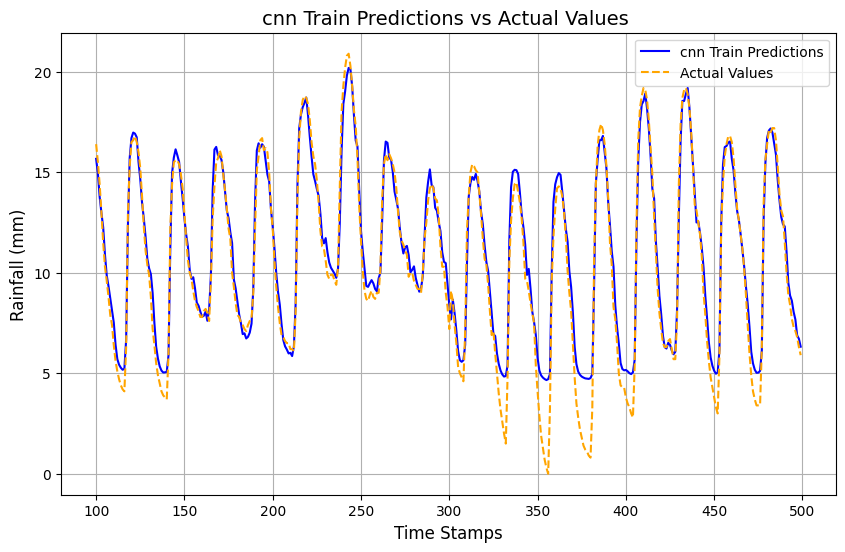

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       cnn Val Predictions  Actual Values
0                10.825773            9.8
1                 9.996010            7.9
2                 8.049293            7.1
3                 7.332058            6.9
4                 7.161586            6.4
...                    ...            ...
21911            25.976782           26.1
21912            25.199347           25.7
21913            25.075758           25.5
21914            24.531246           24.8
21915            24.455120           24.5

[21916 rows x 2 columns]


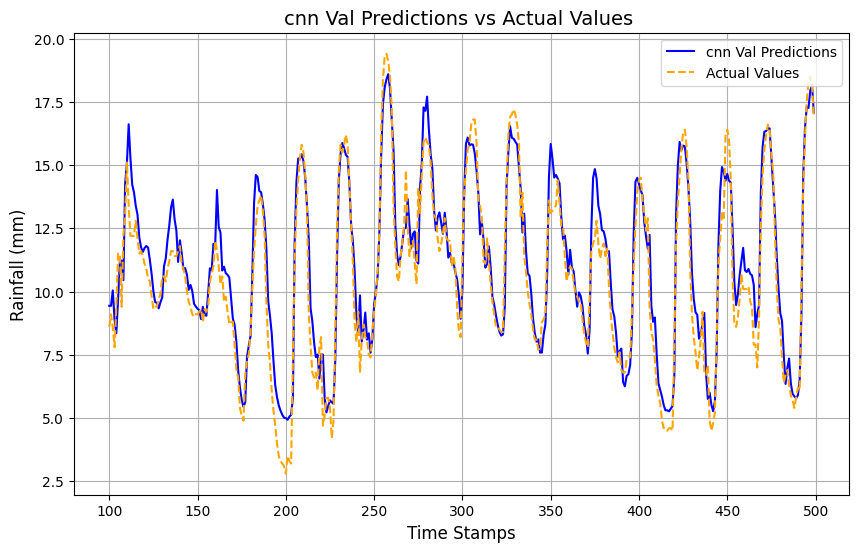

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       cnn Test Predictions  Actual Values
0                 24.062700           23.8
1                 23.298967           23.4
2                 23.107111           23.5
3                 24.170124           23.4
4                 23.440987           23.4
...                     ...            ...
21912              8.171404            8.4
21913              8.064051            8.4
21914              7.922110            8.4
21915              7.766997            8.9
21916              7.880152            8.1

[21917 rows x 2 columns]


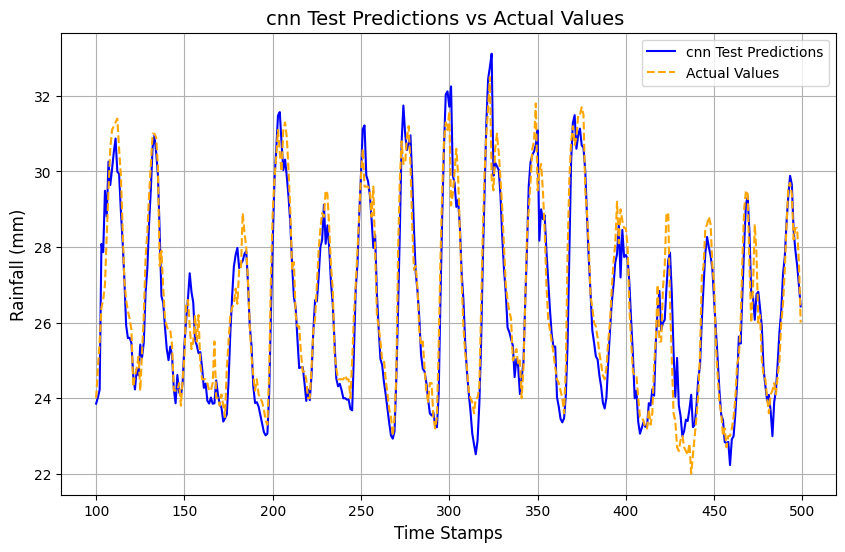


Training LSTM model with MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - loss: 53.1426 - mae: 5.2325 - mse: 53.0340 - root_mean_squared_error: 6.8435 - val_loss: 2.7800 - val_mae: 1.2291 - val_mse: 2.6360 - val_root_mean_squared_error: 1.6236 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 66s 12ms/step - loss: 10.6485 - mae: 2.4983 - mse: 10.4979 - root_mean_squared_error: 3.2385 - val_loss: 1.2650 - val_mae: 0.8055 - val_mse: 1.0971 - val_root_mean_squared_error: 1.0474 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - loss: 7.3672 - mae: 2.0430 - mse: 7.1961 - root_mean_squared_error: 2.6819 - val_loss: 1.2480 - val_mae: 0.8195 - val_mse: 1.0686 - val_root_mean_squared_error: 1.0337 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 63s 12ms/step - loss: 5.6108 - mae: 1.7608 - mse: 5.4306 - root_mean_squared_error: 2.3300 - val_loss: 0.9977 - val_mae: 0.6452 - val_mse: 0.8162 - val_root_mean_squared

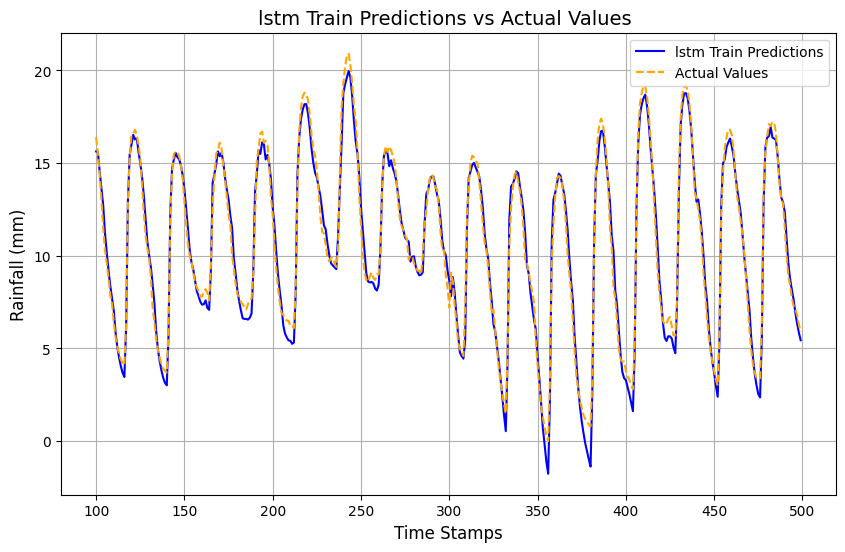

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       lstm Val Predictions  Actual Values
0                 10.572838            9.8
1                  9.323305            7.9
2                  7.948722            7.1
3                  6.719286            6.9
4                  6.006129            6.4
...                     ...            ...
21911             26.572010           26.1
21912             25.435886           25.7
21913             25.051554           25.5
21914             24.701334           24.8
21915             24.408749           24.5

[21916 rows x 2 columns]


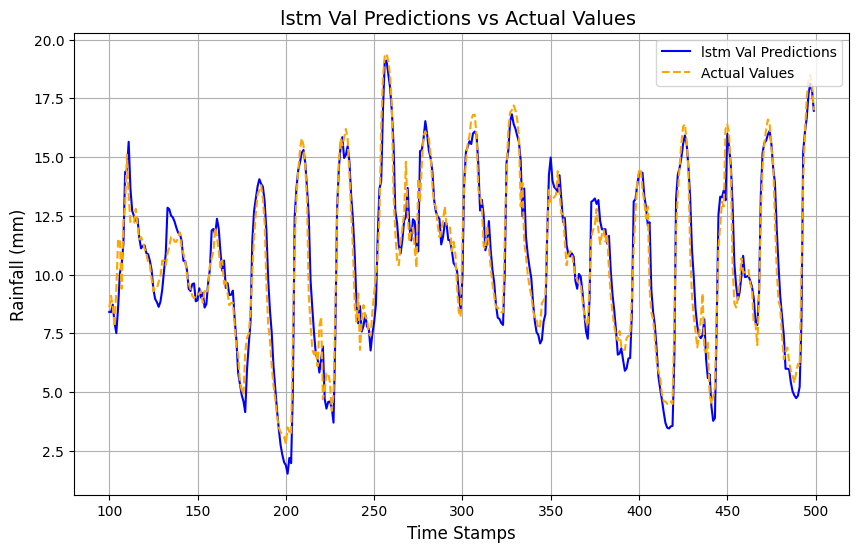

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       lstm Test Predictions  Actual Values
0                  24.322754           23.8
1                  23.458967           23.4
2                  23.220825           23.5
3                  23.337313           23.4
4                  22.813093           23.4
...                      ...            ...
21912               8.433000            8.4
21913               8.229324            8.4
21914               8.245557            8.4
21915               8.204186            8.9
21916               8.153093            8.1

[21917 rows x 2 columns]


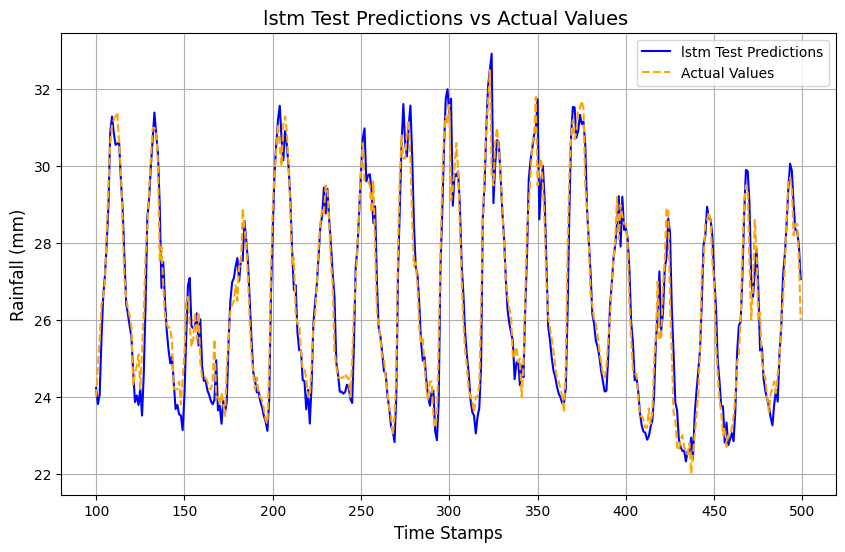


Training GRU model with MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - loss: 46.0905 - mae: 4.8555 - mse: 46.0369 - root_mean_squared_error: 6.3919 - val_loss: 2.4933 - val_mae: 1.1814 - val_mse: 2.4325 - val_root_mean_squared_error: 1.5596 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step - loss: 9.6304 - mae: 2.4010 - mse: 9.5683 - root_mean_squared_error: 3.0915 - val_loss: 1.4918 - val_mae: 0.8991 - val_mse: 1.4265 - val_root_mean_squared_error: 1.1943 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 6.7710 - mae: 1.9806 - mse: 6.7054 - root_mean_squared_error: 2.5890 - val_loss: 1.2067 - val_mae: 0.8052 - val_mse: 1.1404 - val_root_mean_squared_error: 1.0679 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 5.4738 - mae: 1.7753 - mse: 5.4076 - root_mean_squared_error: 2.3252 - val_loss: 1.2073 - val_mae: 0.8093 - val_mse: 1.1402 - val_root_mean_squared_err

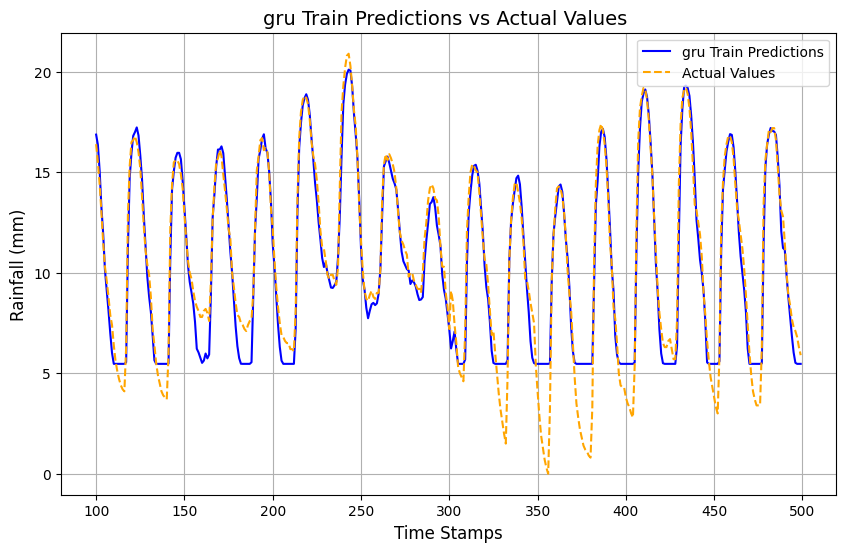

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Val Predictions  Actual Values
0                 9.377224            9.8
1                 8.085299            7.9
2                 6.522182            7.1
3                 5.798510            6.9
4                 5.506278            6.4
...                    ...            ...
21911            26.150141           26.1
21912            25.024151           25.7
21913            24.646381           25.5
21914            24.262611           24.8
21915            23.720362           24.5

[21916 rows x 2 columns]


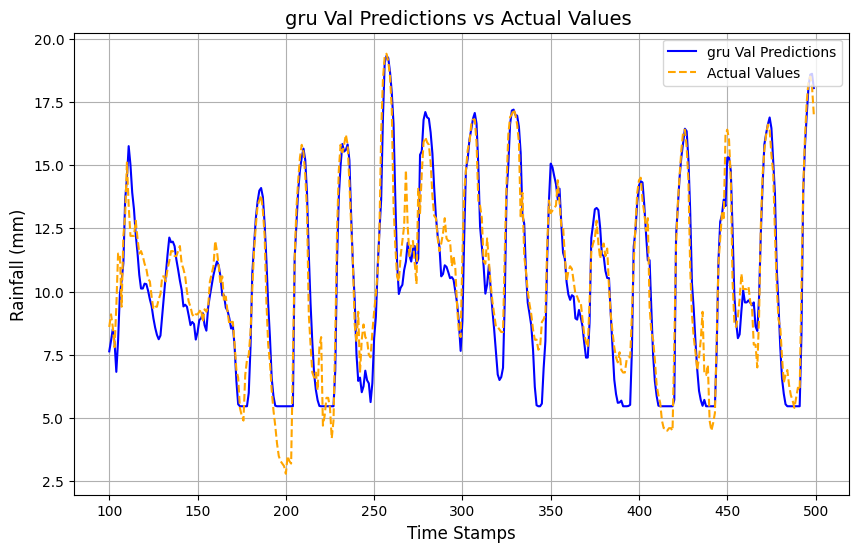

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Test Predictions  Actual Values
0                 23.751692           23.8
1                 23.001740           23.4
2                 22.404808           23.5
3                 22.409243           23.4
4                 22.359030           23.4
...                     ...            ...
21912              5.914770            8.4
21913              5.711598            8.4
21914              6.378793            8.4
21915              7.100711            8.9
21916              7.067893            8.1

[21917 rows x 2 columns]


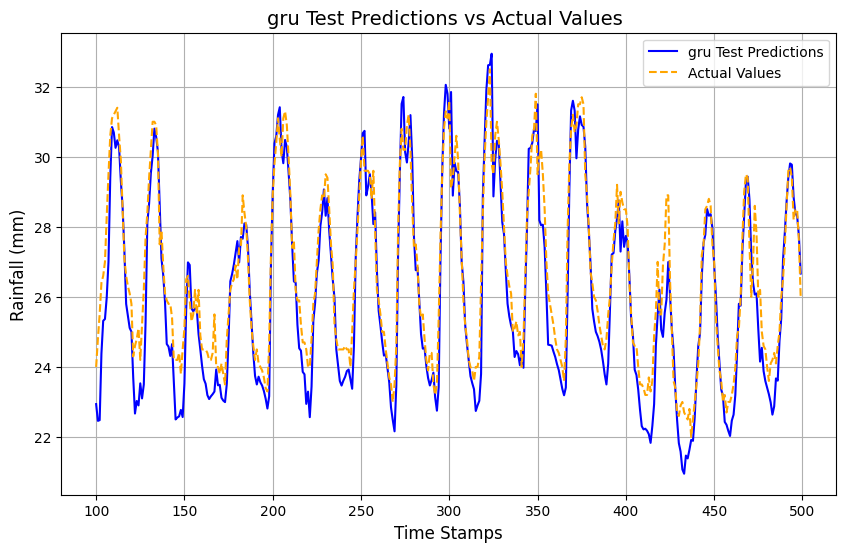

Results for loss function 'mse' saved in '../artifacts/results/mse'.

Training CNN model with MAE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 5.3455 - mae: 5.3240 - mse: 58.2339 - root_mean_squared_error: 7.1503 - val_loss: 1.0314 - val_mae: 1.0090 - val_mse: 1.7012 - val_root_mean_squared_error: 1.3043 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 2.6399 - mae: 2.6171 - mse: 11.6410 - root_mean_squared_error: 3.4112 - val_loss: 1.0648 - val_mae: 1.0403 - val_mse: 1.6999 - val_root_mean_squared_error: 1.3038 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 2.3417 - mae: 2.3164 - mse: 9.1812 - root_mean_squared_error: 3.0297 - val_loss: 1.2043 - val_mae: 1.1770 - val_mse: 2.0636 - val_root_mean_squared_error: 1.4365 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 2.1375 - mae: 2.1094 - mse: 7.6368 - root_mean_squared_error: 2.7631 - val_loss: 1.023

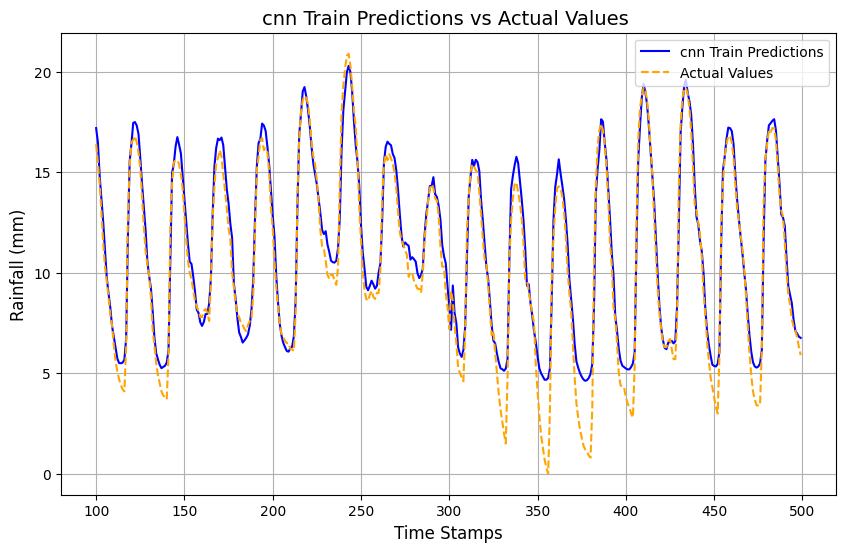

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       cnn Val Predictions  Actual Values
0                10.605562            9.8
1                 9.175997            7.9
2                 7.238284            7.1
3                 6.435507            6.9
4                 6.173031            6.4
...                    ...            ...
21911            26.186470           26.1
21912            25.209358           25.7
21913            24.565063           25.5
21914            24.049772           24.8
21915            23.554264           24.5

[21916 rows x 2 columns]


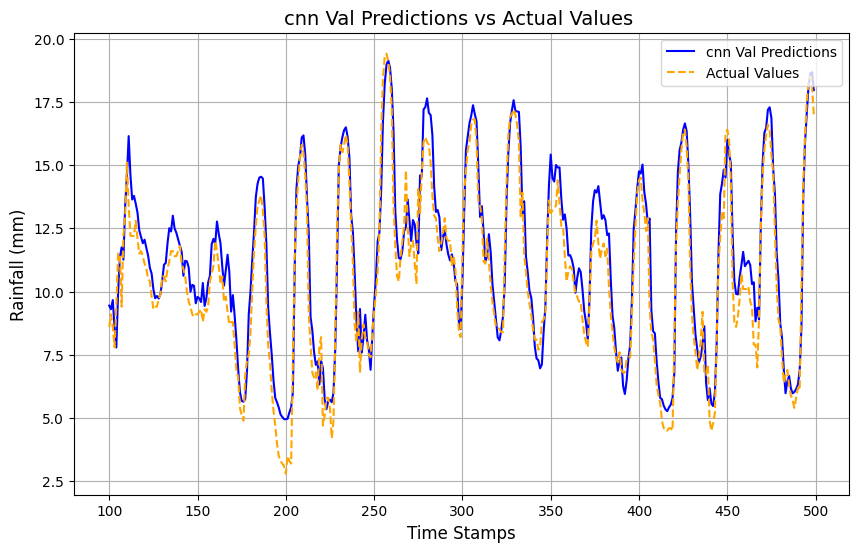

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       cnn Test Predictions  Actual Values
0                 23.256996           23.8
1                 22.774351           23.4
2                 22.190220           23.5
3                 22.861284           23.4
4                 22.873199           23.4
...                     ...            ...
21912              8.732123            8.4
21913              7.678471            8.4
21914              8.310885            8.4
21915              8.620241            8.9
21916              8.556373            8.1

[21917 rows x 2 columns]


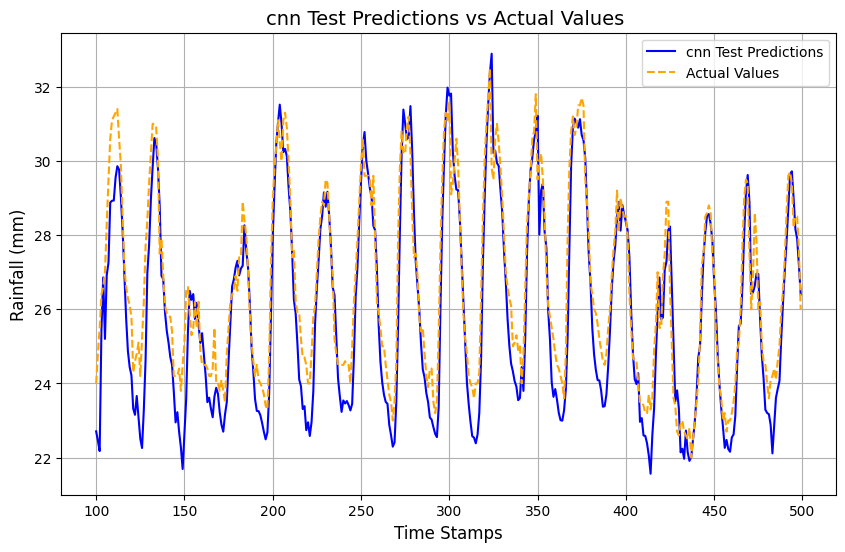


Training LSTM model with MAE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 4.7617 - mae: 4.6639 - mse: 44.7771 - root_mean_squared_error: 6.2830 - val_loss: 1.1096 - val_mae: 1.0043 - val_mse: 1.6544 - val_root_mean_squared_error: 1.2862 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step - loss: 2.4337 - mae: 2.3303 - mse: 9.2904 - root_mean_squared_error: 3.0467 - val_loss: 0.9474 - val_mae: 0.8514 - val_mse: 1.2779 - val_root_mean_squared_error: 1.1305 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - loss: 2.0713 - mae: 1.9788 - mse: 6.7002 - root_mean_squared_error: 2.5882 - val_loss: 1.0861 - val_mae: 1.0015 - val_mse: 1.5631 - val_root_mean_squared_error: 1.2503 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 1.8710 - mae: 1.7885 - mse: 5.5462 - root_mean_squared_error: 2.3549 - val_loss: 0.7822 - val_mae: 0.7045 - val_mse: 0.9743 - val_root_mean_squared_err

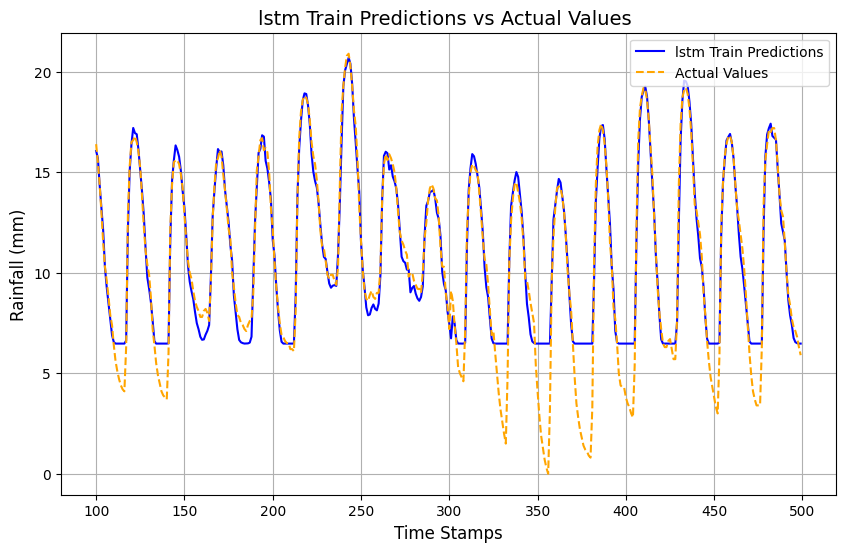

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       lstm Val Predictions  Actual Values
0                 10.000722            9.8
1                  8.524290            7.9
2                  6.824305            7.1
3                  6.496085            6.9
4                  6.475633            6.4
...                     ...            ...
21911             26.665663           26.1
21912             25.782593           25.7
21913             25.313322           25.5
21914             25.096619           24.8
21915             24.601042           24.5

[21916 rows x 2 columns]


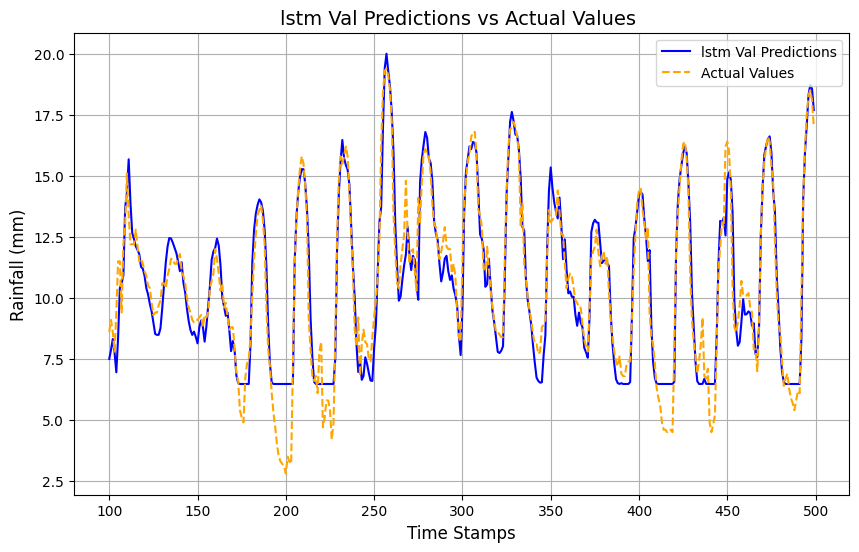

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       lstm Test Predictions  Actual Values
0                  24.423996           23.8
1                  23.773832           23.4
2                  23.036654           23.5
3                  23.787176           23.4
4                  23.187143           23.4
...                      ...            ...
21912               7.119198            8.4
21913               7.167079            8.4
21914               7.481794            8.4
21915               7.570267            8.9
21916               7.794675            8.1

[21917 rows x 2 columns]


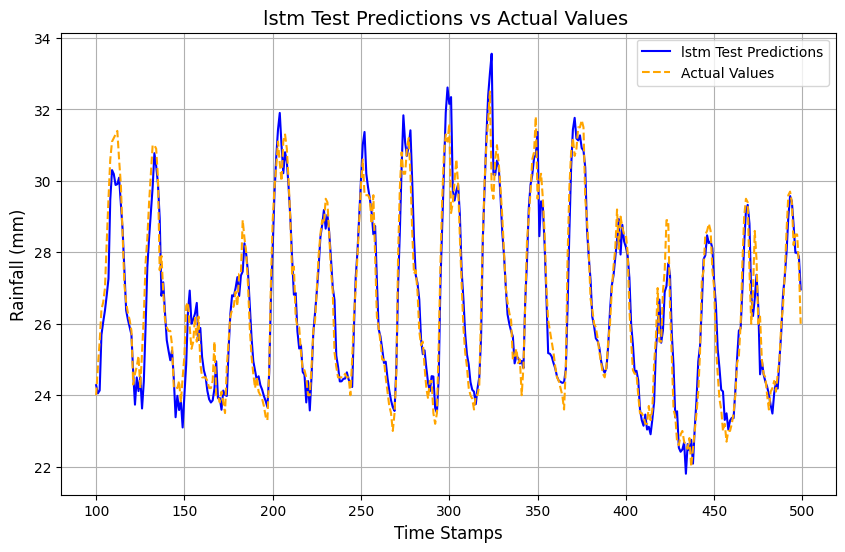


Training GRU model with MAE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - loss: 5.4227 - mae: 5.3711 - mse: 56.5016 - root_mean_squared_error: 7.1203 - val_loss: 1.3512 - val_mae: 1.2965 - val_mse: 2.7073 - val_root_mean_squared_error: 1.6454 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 2.6417 - mae: 2.5870 - mse: 11.4763 - root_mean_squared_error: 3.3854 - val_loss: 1.0373 - val_mae: 0.9832 - val_mse: 1.6185 - val_root_mean_squared_error: 1.2722 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 66s 12ms/step - loss: 2.1577 - mae: 2.1040 - mse: 7.5429 - root_mean_squared_error: 2.7459 - val_loss: 0.8848 - val_mae: 0.8323 - val_mse: 1.2318 - val_root_mean_squared_error: 1.1099 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - loss: 1.8938 - mae: 1.8428 - mse: 5.8682 - root_mean_squared_error: 2.4222 - val_loss: 0.9834 - val_mae: 0.9363 - val_mse: 1.4394 - val_root_mean_squared_err

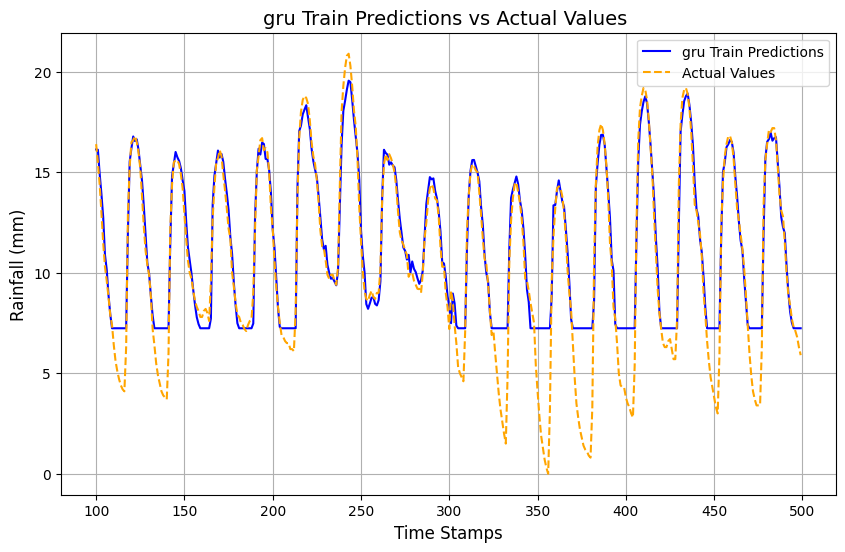

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       gru Val Predictions  Actual Values
0                10.873240            9.8
1                 8.558702            7.9
2                 7.276494            7.1
3                 7.238516            6.9
4                 7.238516            6.4
...                    ...            ...
21911            26.945726           26.1
21912            25.809452           25.7
21913            24.989231           25.5
21914            24.570318           24.8
21915            24.141153           24.5

[21916 rows x 2 columns]


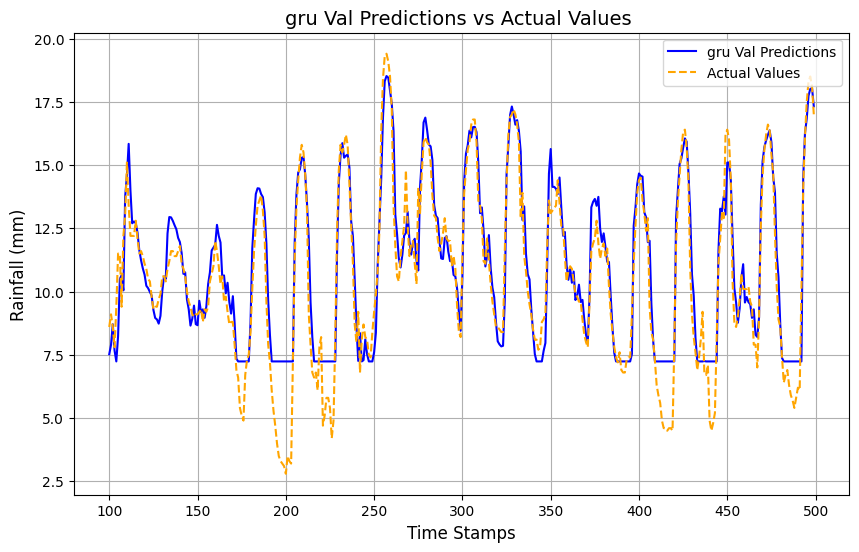

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       gru Test Predictions  Actual Values
0                 23.926067           23.8
1                 23.243975           23.4
2                 22.409199           23.5
3                 23.103521           23.4
4                 22.803127           23.4
...                     ...            ...
21912              8.326345            8.4
21913              8.297347            8.4
21914              8.829621            8.4
21915              8.848420            8.9
21916              8.841602            8.1

[21917 rows x 2 columns]


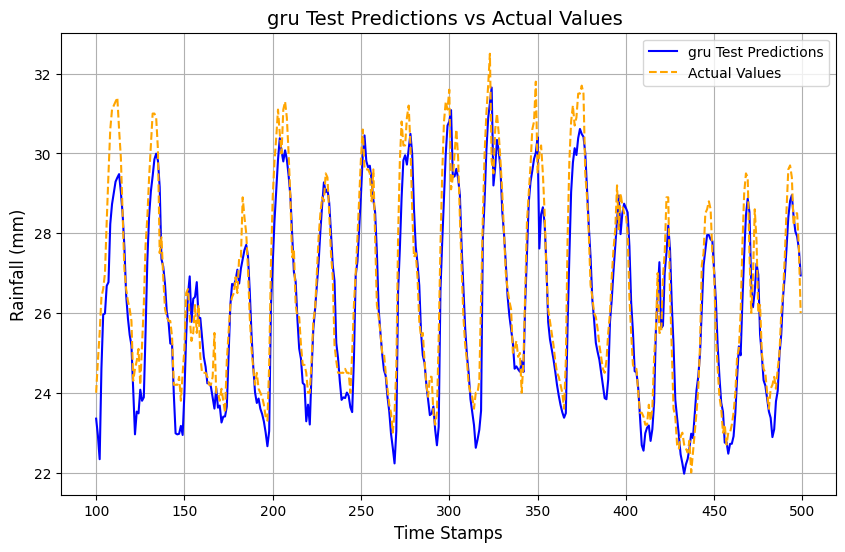

Results for loss function 'mae' saved in '../artifacts/results/mae'.

Training CNN model with HUBER loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 5.0056 - mae: 5.4575 - mse: 61.7407 - root_mean_squared_error: 7.3481 - val_loss: 0.9515 - val_mae: 1.3589 - val_mse: 2.7739 - val_root_mean_squared_error: 1.6655 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 2.2119 - mae: 2.6451 - mse: 12.0027 - root_mean_squared_error: 3.4636 - val_loss: 0.6708 - val_mae: 1.0507 - val_mse: 1.7255 - val_root_mean_squared_error: 1.3136 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.8843 - mae: 2.3082 - mse: 9.1999 - root_mean_squared_error: 3.0328 - val_loss: 0.7738 - val_mae: 1.1714 - val_mse: 2.0051 - val_root_mean_squared_error: 1.4160 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 1.6504 - mae: 2.0657 - mse: 7.3922 - root_mean_squared_error: 2.7185 - val_loss: 0.5

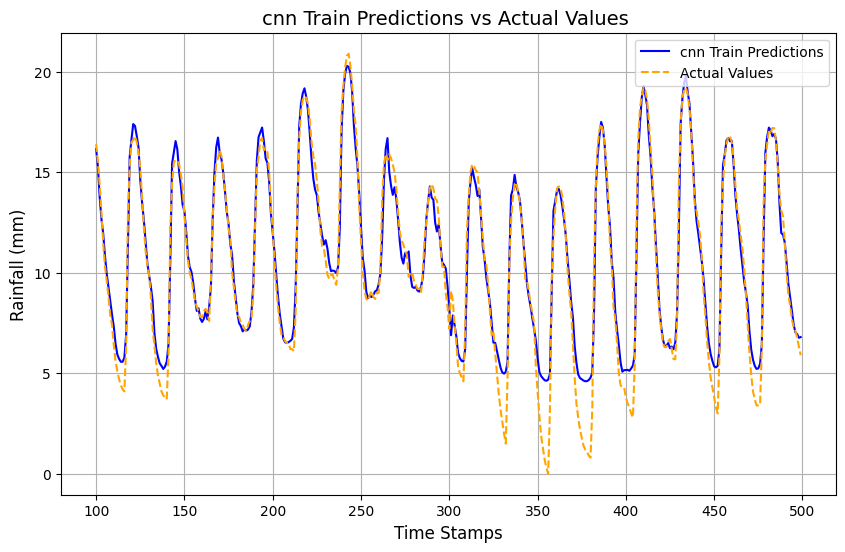

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       cnn Val Predictions  Actual Values
0                10.102468            9.8
1                 9.302860            7.9
2                 7.368356            7.1
3                 6.740116            6.9
4                 6.551503            6.4
...                    ...            ...
21911            25.509357           26.1
21912            24.637890           25.7
21913            24.466900           25.5
21914            24.105532           24.8
21915            23.994152           24.5

[21916 rows x 2 columns]


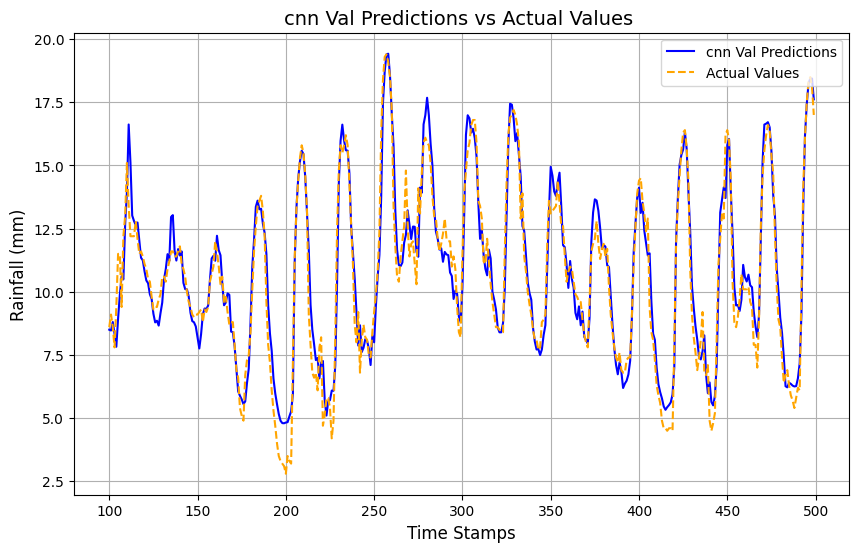

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       cnn Test Predictions  Actual Values
0                 23.794155           23.8
1                 23.575472           23.4
2                 22.852982           23.5
3                 23.263689           23.4
4                 23.325167           23.4
...                     ...            ...
21912              8.025792            8.4
21913              7.643710            8.4
21914              7.735693            8.4
21915              7.723005            8.9
21916              7.544708            8.1

[21917 rows x 2 columns]


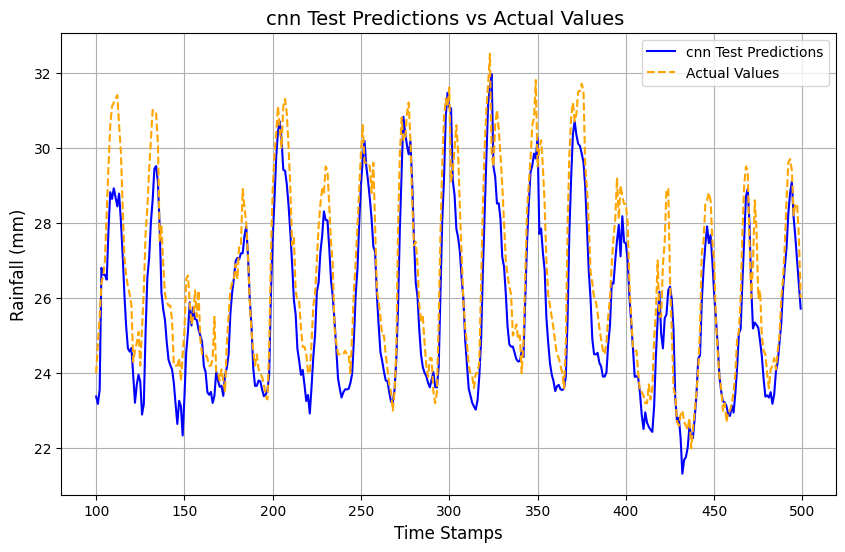


Training LSTM model with HUBER loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - loss: 4.2535 - mae: 4.6299 - mse: 42.8718 - root_mean_squared_error: 6.2011 - val_loss: 0.8752 - val_mae: 1.1979 - val_mse: 2.1995 - val_root_mean_squared_error: 1.4831 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - loss: 1.9319 - mae: 2.2852 - mse: 8.9088 - root_mean_squared_error: 2.9831 - val_loss: 0.5546 - val_mae: 0.8407 - val_mse: 1.2072 - val_root_mean_squared_error: 1.0987 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 1.5779 - mae: 1.9307 - mse: 6.4572 - root_mean_squared_error: 2.5405 - val_loss: 0.5821 - val_mae: 0.8949 - val_mse: 1.2564 - val_root_mean_squared_error: 1.1209 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 95s 17ms/step - loss: 1.3821 - mae: 1.7380 - mse: 5.2406 - root_mean_squared_error: 2.2891 - val_loss: 0.4221 - val_mae: 0.6812 - val_mse: 0.9188 - val_root_mean_squared_e

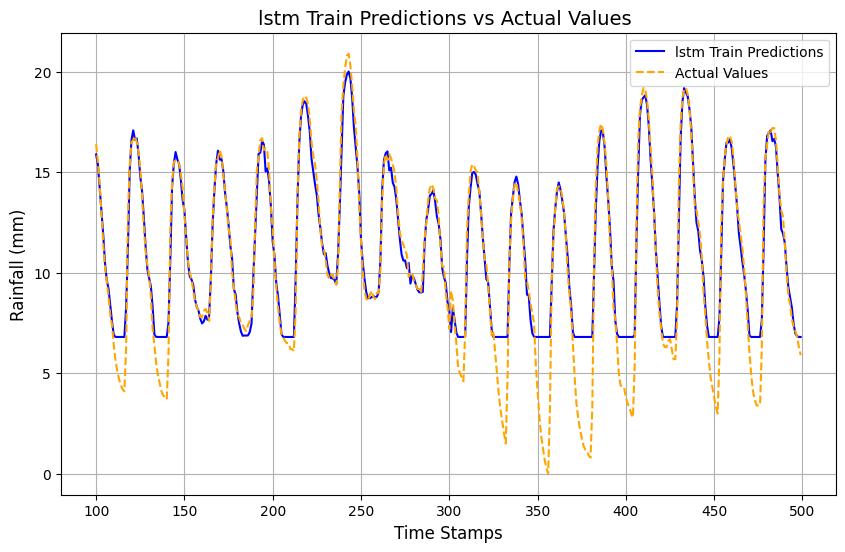

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
       lstm Val Predictions  Actual Values
0                 10.287036            9.8
1                  8.965890            7.9
2                  7.389192            7.1
3                  6.810191            6.9
4                  6.805530            6.4
...                     ...            ...
21911             26.862034           26.1
21912             25.802582           25.7
21913             25.225033           25.5
21914             24.897829           24.8
21915             24.428780           24.5

[21916 rows x 2 columns]


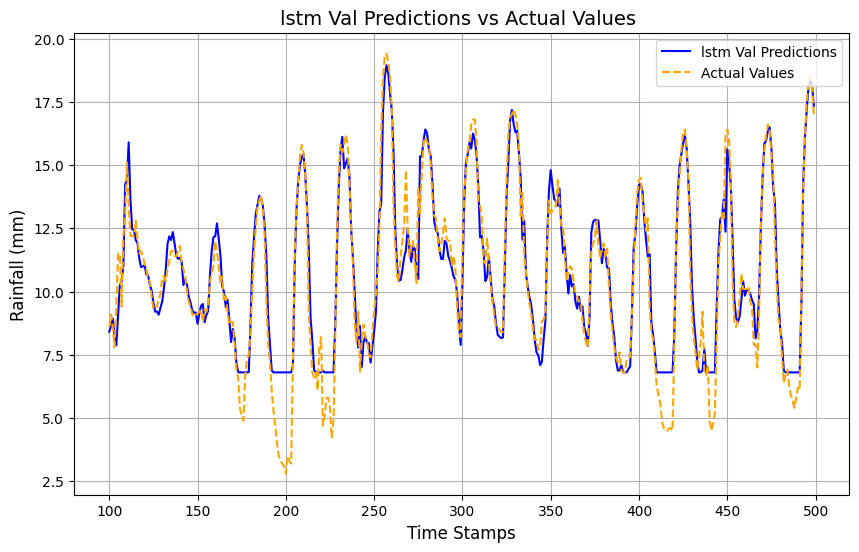

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       lstm Test Predictions  Actual Values
0                  24.294636           23.8
1                  23.267616           23.4
2                  23.466124           23.5
3                  24.147469           23.4
4                  23.669521           23.4
...                      ...            ...
21912               7.421713            8.4
21913               7.489492            8.4
21914               7.819619            8.4
21915               8.138622            8.9
21916               8.268269            8.1

[21917 rows x 2 columns]


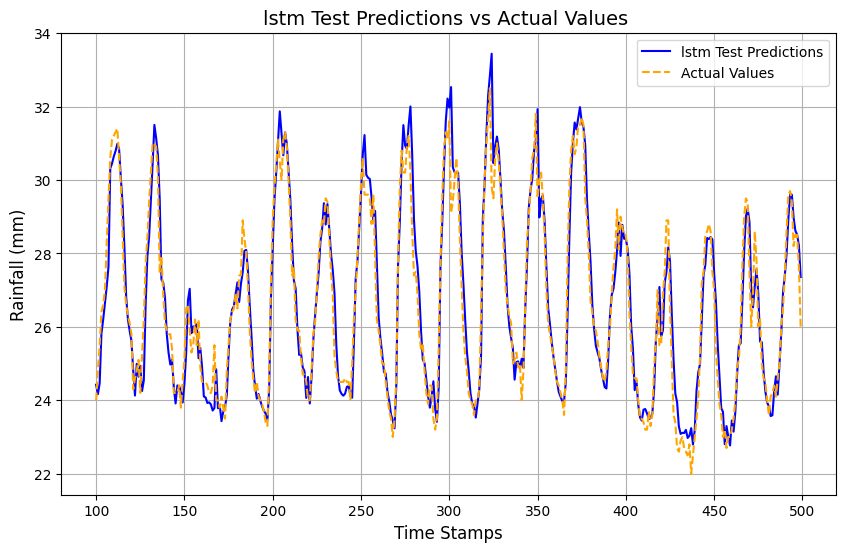


Training GRU model with HUBER loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - loss: 4.1064 - mae: 4.5279 - mse: 40.9719 - root_mean_squared_error: 6.0462 - val_loss: 0.7824 - val_mae: 1.1425 - val_mse: 2.0812 - val_root_mean_squared_error: 1.4426 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 1.8993 - mae: 2.3011 - mse: 9.0127 - root_mean_squared_error: 3.0003 - val_loss: 0.5740 - val_mae: 0.9189 - val_mse: 1.3619 - val_root_mean_squared_error: 1.1670 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - loss: 1.5150 - mae: 1.9106 - mse: 6.3106 - root_mean_squared_error: 2.5117 - val_loss: 0.4584 - val_mae: 0.7749 - val_mse: 1.0777 - val_root_mean_squared_error: 1.0381 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 88s 16ms/step - loss: 1.3399 - mae: 1.7325 - mse: 5.1899 - root_mean_squared_error: 2.2780 - val_loss: 0.4828 - val_mae: 0.8148 - val_mse: 1.1439 - val_root_mean_squared_er

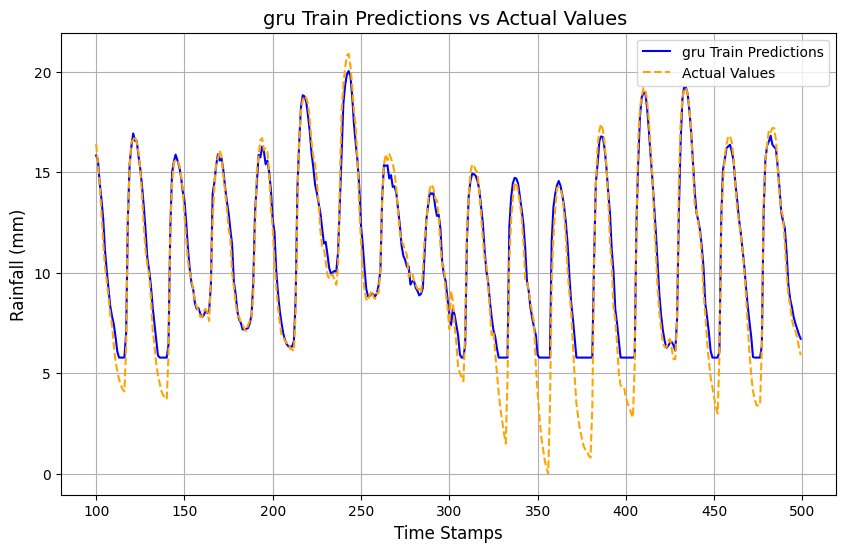

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Val Predictions  Actual Values
0                10.589064            9.8
1                 9.476980            7.9
2                 7.992476            7.1
3                 7.063913            6.9
4                 6.628356            6.4
...                    ...            ...
21911            26.748987           26.1
21912            25.331364           25.7
21913            24.651937           25.5
21914            24.004459           24.8
21915            23.726435           24.5

[21916 rows x 2 columns]


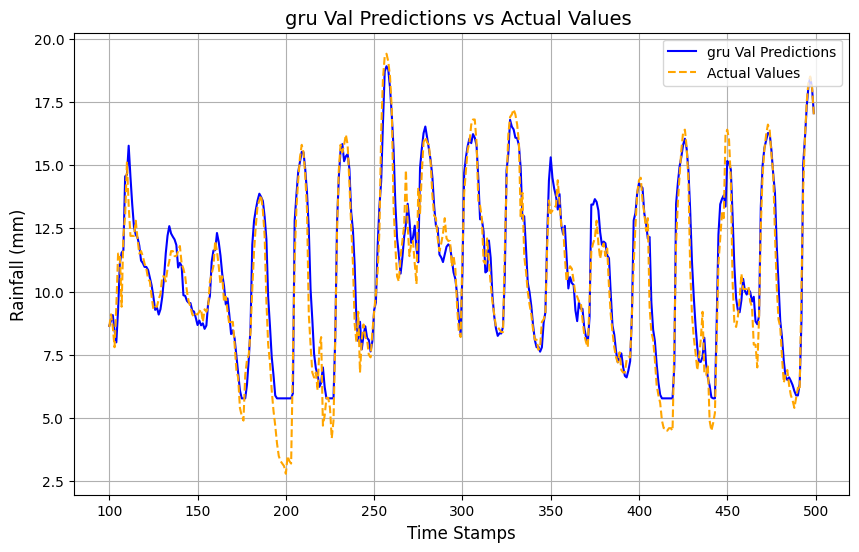

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Test Predictions  Actual Values
0                 23.795725           23.8
1                 22.764839           23.4
2                 21.915228           23.5
3                 22.662802           23.4
4                 22.567083           23.4
...                     ...            ...
21912              7.858913            8.4
21913              7.836391            8.4
21914              7.951974            8.4
21915              8.074353            8.9
21916              8.210472            8.1

[21917 rows x 2 columns]


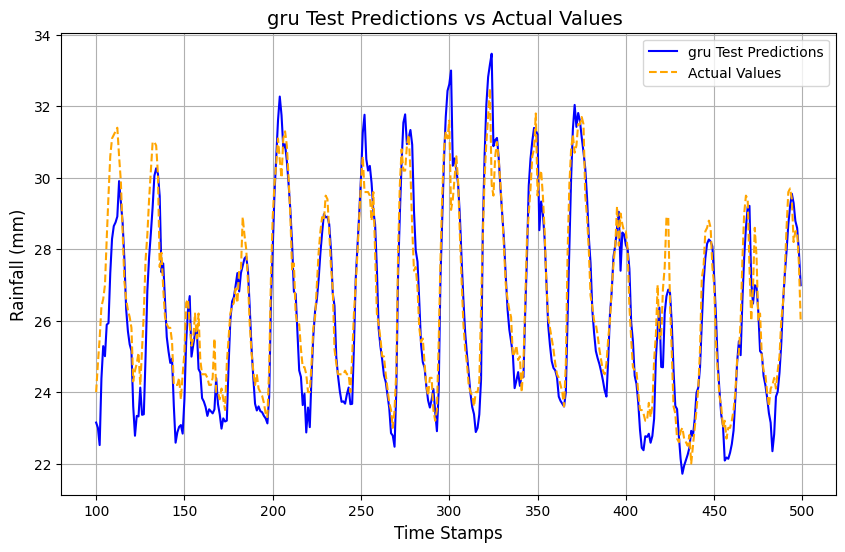

Results for loss function 'huber' saved in '../artifacts/results/huber'.

Training CNN model with WEIGHTED_MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 101.5857 - mae: 5.5650 - mse: 59.0874 - root_mean_squared_error: 7.2939 - val_loss: 2.7025 - val_mae: 1.0205 - val_mse: 1.8687 - val_root_mean_squared_error: 1.3670 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 20.2287 - mae: 2.9232 - mse: 14.3752 - root_mean_squared_error: 3.7898 - val_loss: 2.0963 - val_mae: 0.9761 - val_mse: 1.6865 - val_root_mean_squared_error: 1.2987 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 14.7315 - mae: 2.5001 - mse: 10.5201 - root_mean_squared_error: 3.2431 - val_loss: 2.3068 - val_mae: 1.0642 - val_mse: 1.9716 - val_root_mean_squared_error: 1.4041 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 11.6974 - mae: 2.2259 - mse: 8.3777 - root_mean_squared_error: 2.893

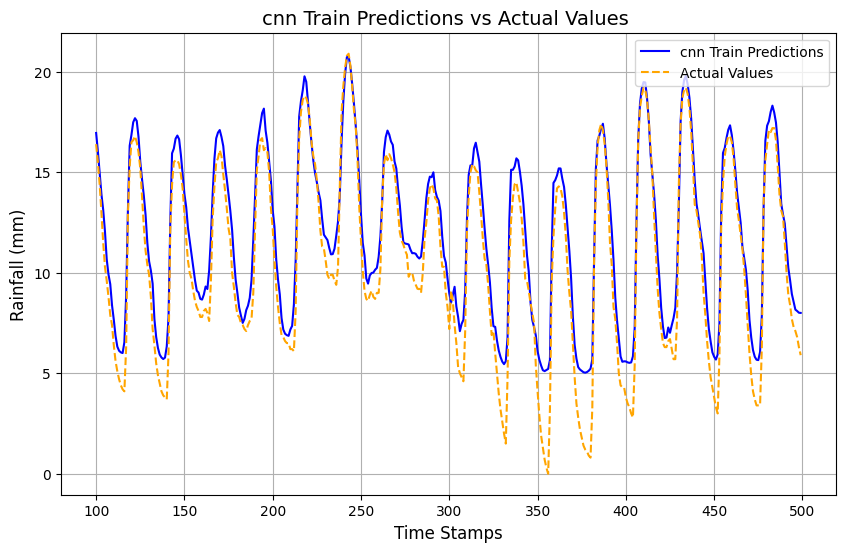

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       cnn Val Predictions  Actual Values
0                11.311367            9.8
1                10.412593            7.9
2                 8.459291            7.1
3                 7.548075            6.9
4                 7.004217            6.4
...                    ...            ...
21911            26.196964           26.1
21912            25.437401           25.7
21913            25.047825           25.5
21914            24.767706           24.8
21915            24.406578           24.5

[21916 rows x 2 columns]


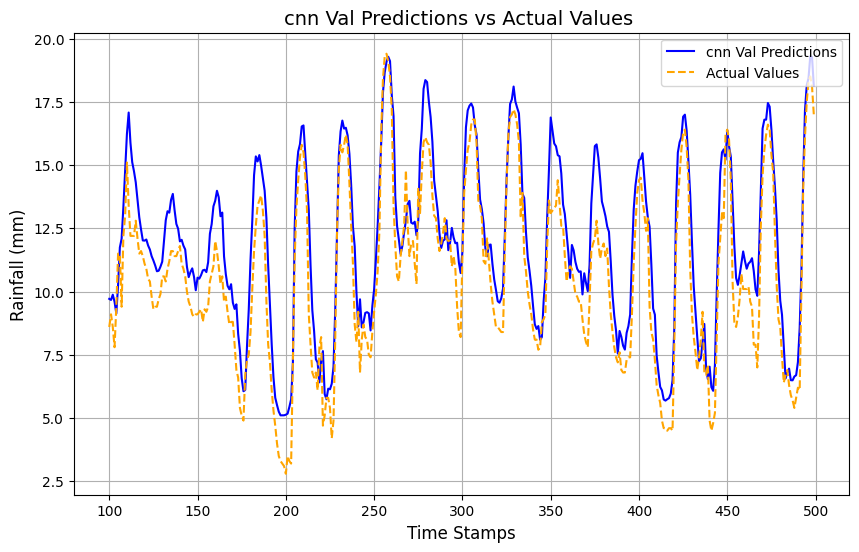

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       cnn Test Predictions  Actual Values
0                 23.989672           23.8
1                 23.858046           23.4
2                 22.655380           23.5
3                 23.435011           23.4
4                 23.391262           23.4
...                     ...            ...
21912              8.734662            8.4
21913              8.452353            8.4
21914              8.984413            8.4
21915              8.977209            8.9
21916              9.151850            8.1

[21917 rows x 2 columns]


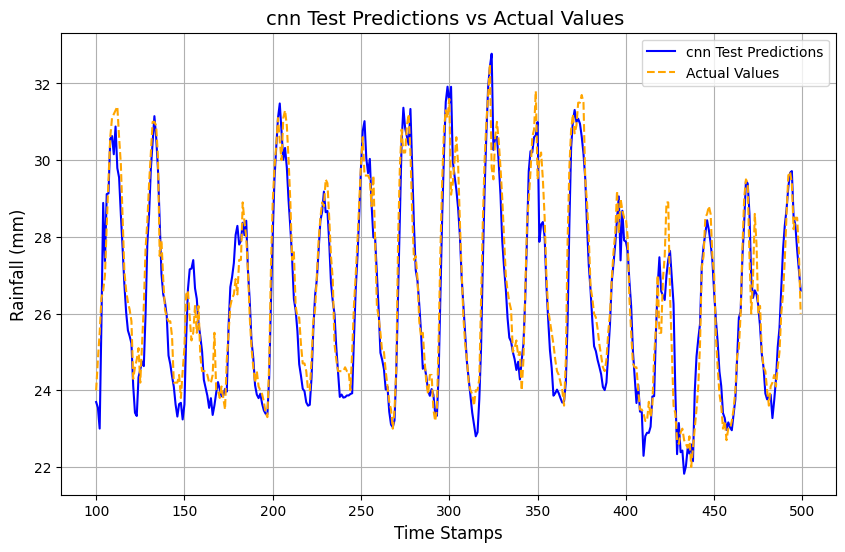


Training LSTM model with WEIGHTED_MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - loss: 84.7806 - mae: 5.1221 - mse: 49.3201 - root_mean_squared_error: 6.6635 - val_loss: 2.6558 - val_mae: 0.9643 - val_mse: 1.7416 - val_root_mean_squared_error: 1.3197 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 14.2718 - mae: 2.4808 - mse: 10.1786 - root_mean_squared_error: 3.1893 - val_loss: 1.9456 - val_mae: 0.8135 - val_mse: 1.2470 - val_root_mean_squared_error: 1.1167 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - loss: 10.1124 - mae: 2.0685 - mse: 7.2060 - root_mean_squared_error: 2.6839 - val_loss: 1.8034 - val_mae: 0.9118 - val_mse: 1.4657 - val_root_mean_squared_error: 1.2107 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 7.8222 - mae: 1.8041 - mse: 5.5562 - root_mean_squared_error: 2.3568 - val_loss: 1.9494 - val_mae: 1.0254 - val_mse: 1.6583 - val_root_mea

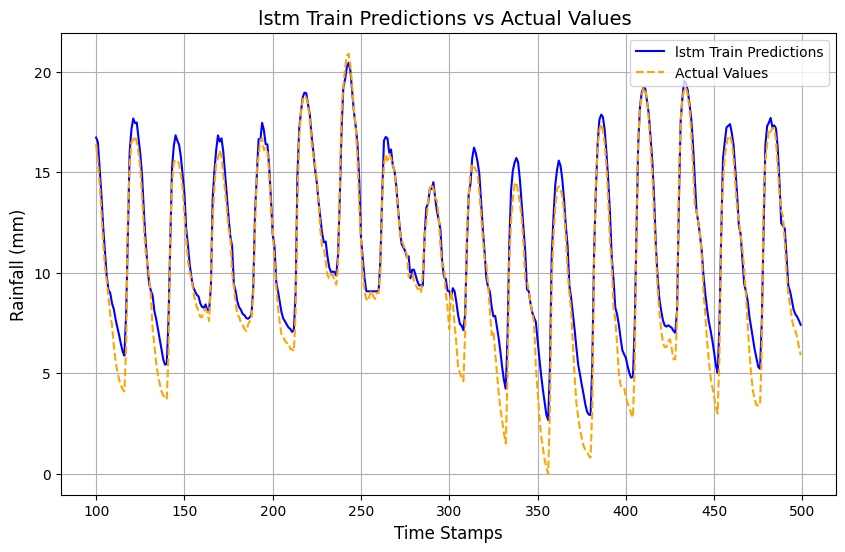

685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
       lstm Val Predictions  Actual Values
0                 10.315786            9.8
1                  9.099588            7.9
2                  8.183583            7.1
3                  7.712906            6.9
4                  7.696969            6.4
...                     ...            ...
21911             26.044876           26.1
21912             24.952248           25.7
21913             24.805771           25.5
21914             24.653149           24.8
21915             24.093796           24.5

[21916 rows x 2 columns]


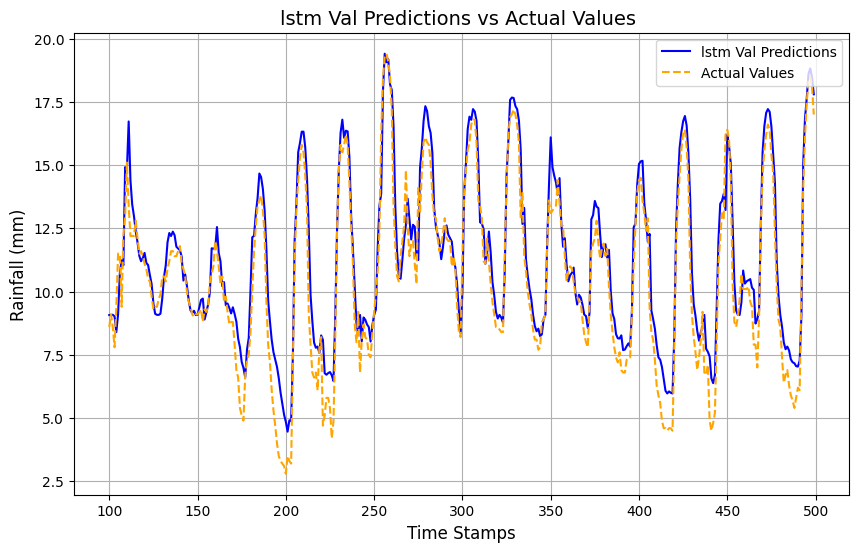

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
       lstm Test Predictions  Actual Values
0                  23.956585           23.8
1                  23.083790           23.4
2                  22.682747           23.5
3                  23.127144           23.4
4                  22.841911           23.4
...                      ...            ...
21912               9.077836            8.4
21913               9.077836            8.4
21914               9.116180            8.4
21915               9.278706            8.9
21916               9.228942            8.1

[21917 rows x 2 columns]


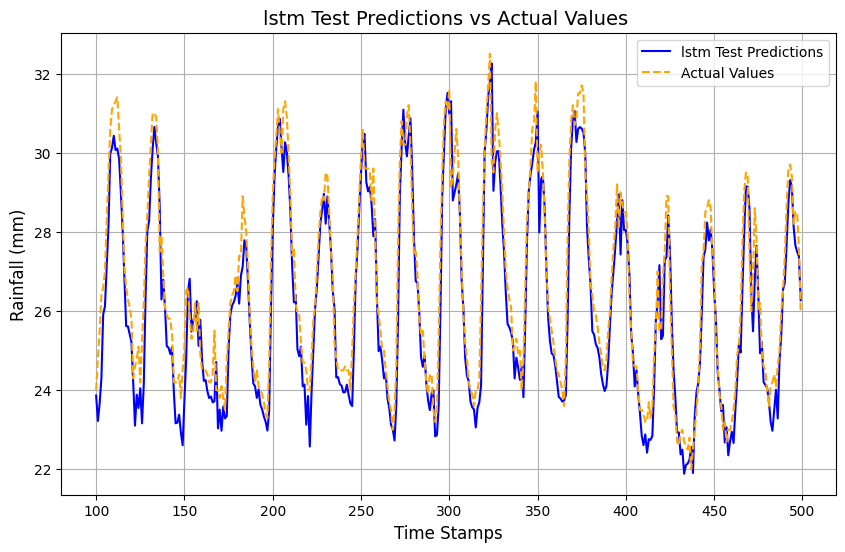


Training GRU model with WEIGHTED_MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - loss: 86.0078 - mae: 5.1233 - mse: 50.2110 - root_mean_squared_error: 6.7187 - val_loss: 3.6842 - val_mae: 1.1422 - val_mse: 2.0625 - val_root_mean_squared_error: 1.4362 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - loss: 14.5638 - mae: 2.5065 - mse: 10.4301 - root_mean_squared_error: 3.2281 - val_loss: 2.1306 - val_mae: 0.9877 - val_mse: 1.6465 - val_root_mean_squared_error: 1.2832 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - loss: 10.2204 - mae: 2.0855 - mse: 7.3519 - root_mean_squared_error: 2.7107 - val_loss: 1.9187 - val_mae: 0.8793 - val_mse: 1.3507 - val_root_mean_squared_error: 1.1622 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - loss: 7.7815 - mae: 1.8204 - mse: 5.6416 - root_mean_squared_error: 2.3749 - val_loss: 1.7697 - val_mae: 0.8496 - val_mse: 1.1952 - val_root_mean

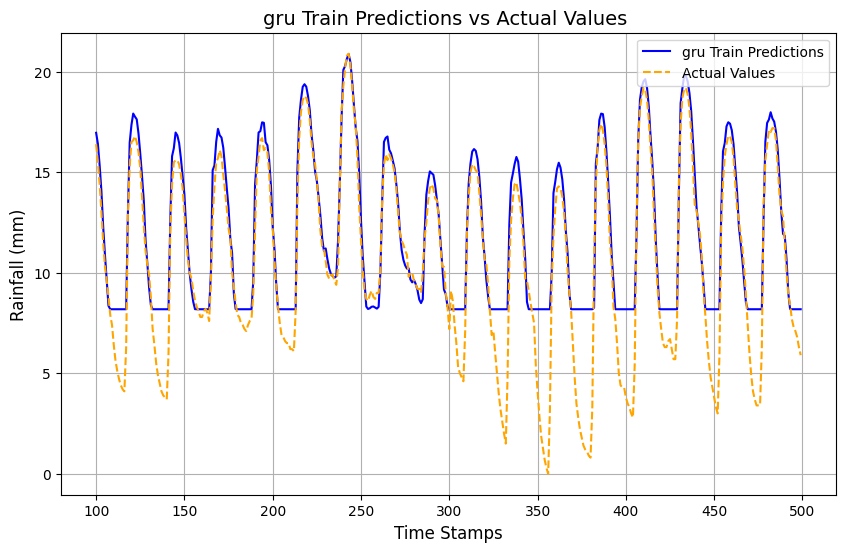

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Val Predictions  Actual Values
0                10.065869            9.8
1                 8.320951            7.9
2                 8.185020            7.1
3                 8.185020            6.9
4                 8.185020            6.4
...                    ...            ...
21911            26.482224           26.1
21912            25.542141           25.7
21913            25.125904           25.5
21914            24.822372           24.8
21915            24.594952           24.5

[21916 rows x 2 columns]


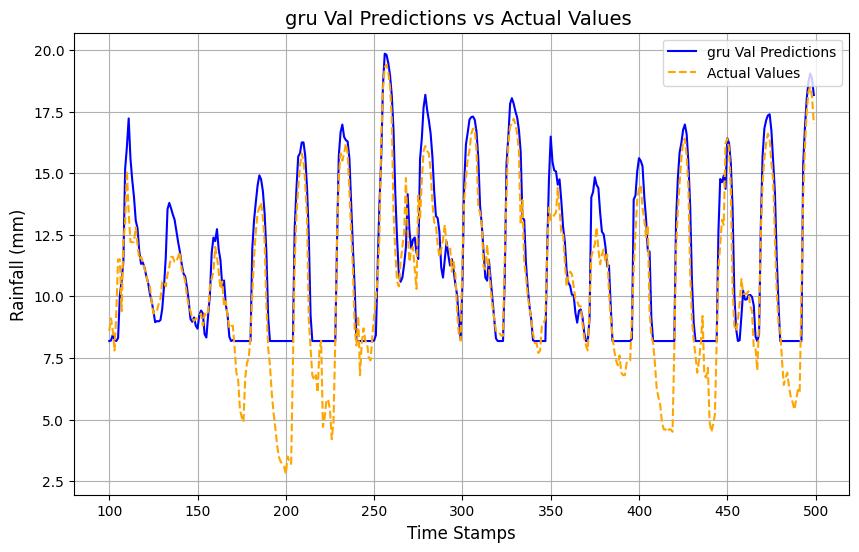

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Test Predictions  Actual Values
0                 24.371475           23.8
1                 23.950676           23.4
2                 23.482708           23.5
3                 23.394087           23.4
4                 23.197754           23.4
...                     ...            ...
21912              8.185020            8.4
21913              8.185020            8.4
21914              8.185020            8.4
21915              8.185020            8.9
21916              8.185020            8.1

[21917 rows x 2 columns]


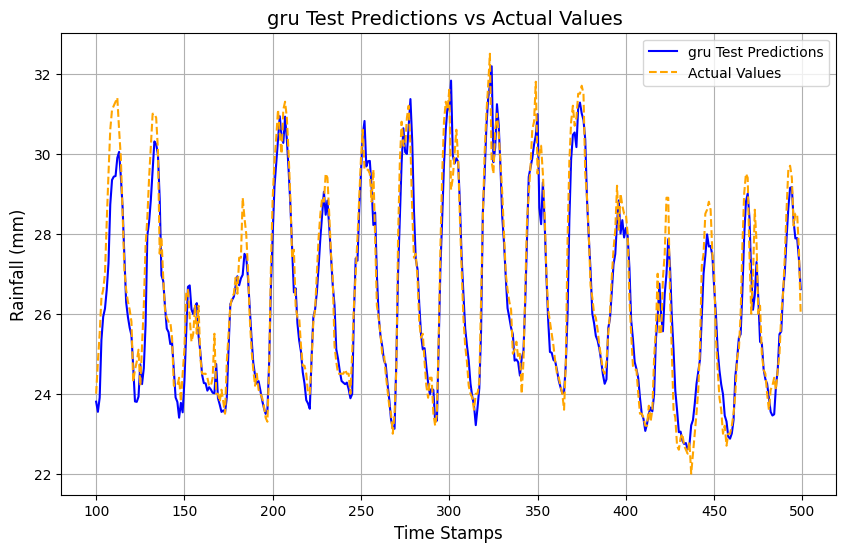

Results for loss function 'weighted_mse' saved in '../artifacts/results/weighted_mse'.

Training CNN model with CUSTOM loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 90.5212 - mae: 5.2339 - mse: 50.7294 - root_mean_squared_error: 6.7876 - val_loss: 3.0738 - val_mae: 1.0694 - val_mse: 1.8921 - val_root_mean_squared_error: 1.3755 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 17.6939 - mae: 2.6202 - mse: 11.5304 - root_mean_squared_error: 3.3943 - val_loss: 3.1903 - val_mae: 1.0989 - val_mse: 1.8882 - val_root_mean_squared_error: 1.3741 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 13.2262 - mae: 2.2622 - mse: 8.6045 - root_mean_squared_error: 2.9328 - val_loss: 1.8389 - val_mae: 0.8235 - val_mse: 1.1738 - val_root_mean_squared_error: 1.0834 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 10.6922 - mae: 2.0347 - mse: 6.9670 - root_mean_squared_error:

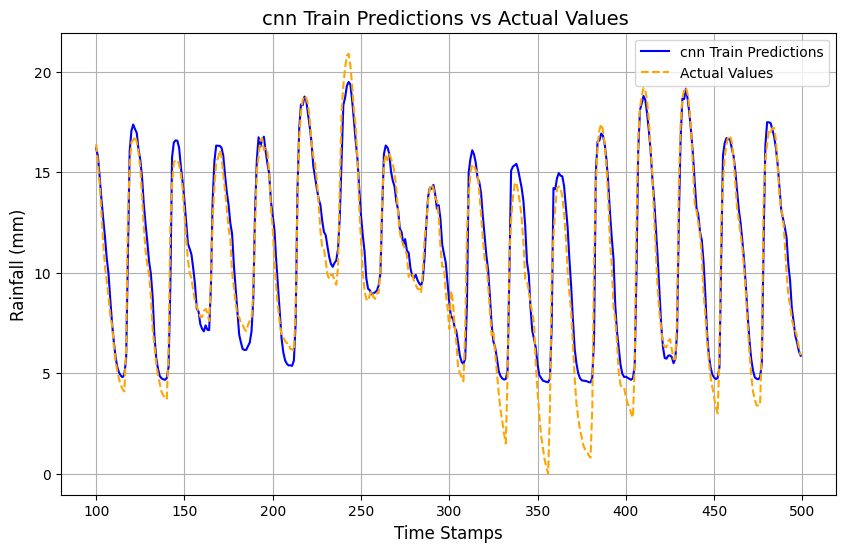

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       cnn Val Predictions  Actual Values
0                11.005869            9.8
1                10.352198            7.9
2                 7.748796            7.1
3                 6.838774            6.9
4                 6.226666            6.4
...                    ...            ...
21911            26.071939           26.1
21912            25.267416           25.7
21913            24.791149           25.5
21914            24.465532           24.8
21915            24.034008           24.5

[21916 rows x 2 columns]


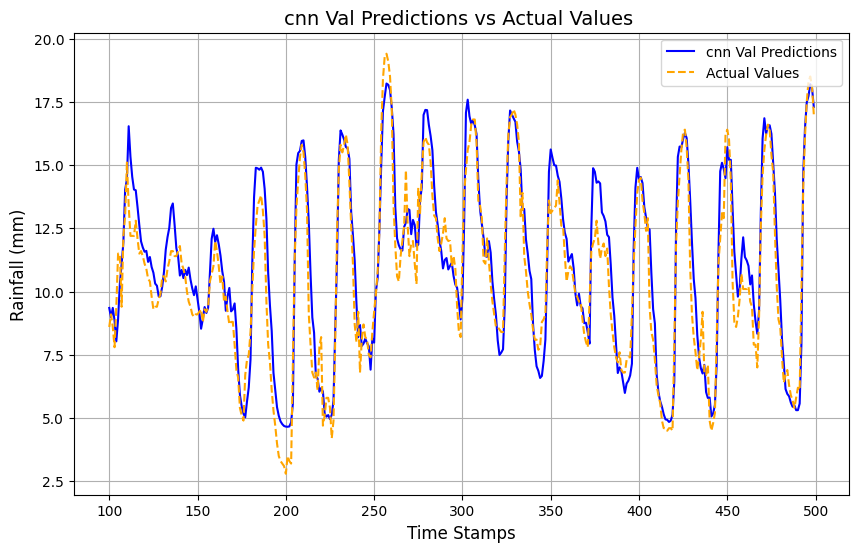

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       cnn Test Predictions  Actual Values
0                 23.704327           23.8
1                 23.341995           23.4
2                 22.579042           23.5
3                 22.826525           23.4
4                 22.989529           23.4
...                     ...            ...
21912              7.358478            8.4
21913              7.546147            8.4
21914              7.970330            8.4
21915              7.952006            8.9
21916              7.521804            8.1

[21917 rows x 2 columns]


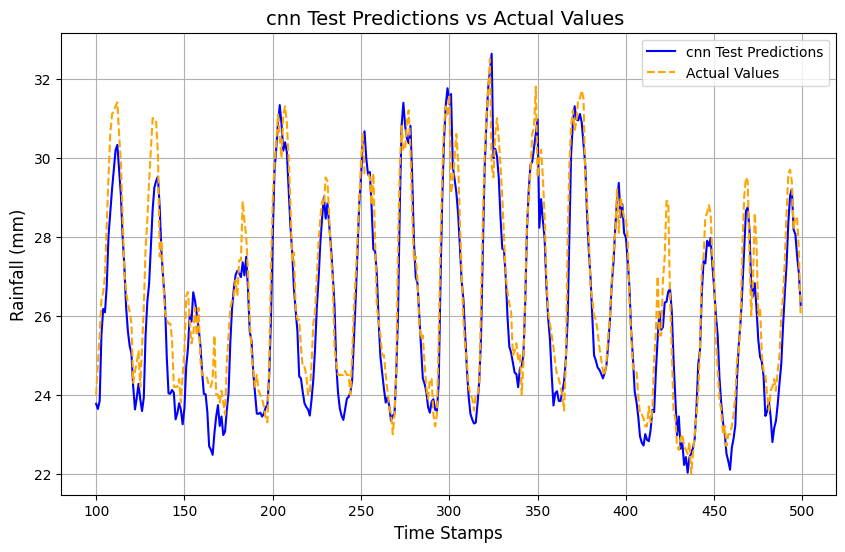


Training LSTM model with CUSTOM loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 91.8590 - mae: 5.1228 - mse: 50.8029 - root_mean_squared_error: 6.7145 - val_loss: 3.2577 - val_mae: 1.0575 - val_mse: 2.0069 - val_root_mean_squared_error: 1.4167 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - loss: 15.9749 - mae: 2.4739 - mse: 10.2243 - root_mean_squared_error: 3.1961 - val_loss: 2.1419 - val_mae: 0.8686 - val_mse: 1.2341 - val_root_mean_squared_error: 1.1109 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - loss: 11.1125 - mae: 2.0444 - mse: 7.1110 - root_mean_squared_error: 2.6662 - val_loss: 2.0928 - val_mae: 0.8988 - val_mse: 1.2792 - val_root_mean_squared_error: 1.1310 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - loss: 8.4341 - mae: 1.7647 - mse: 5.3878 - root_mean_squared_error: 2.3208 - val_loss: 1.7024 - val_mae: 0.7125 - val_mse: 0.8881 - val_root_mean_squa

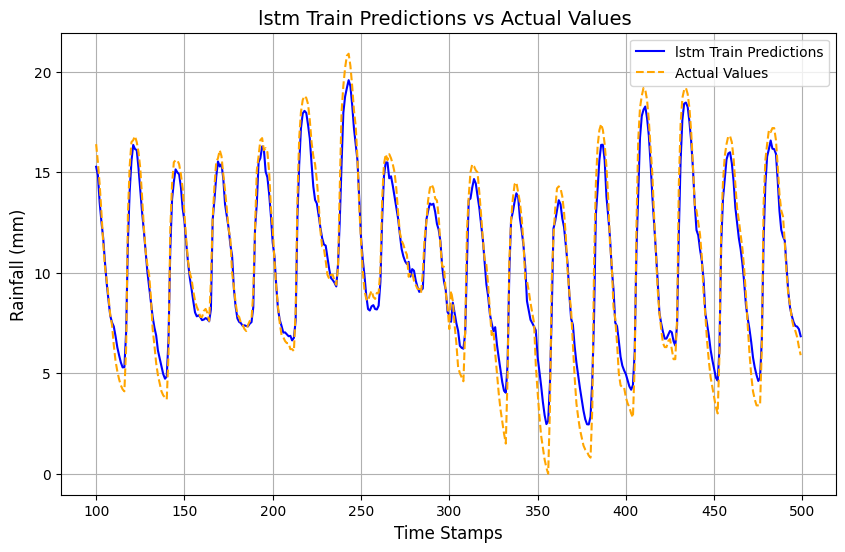

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
       lstm Val Predictions  Actual Values
0                  9.662169            9.8
1                  8.486379            7.9
2                  7.470774            7.1
3                  7.129657            6.9
4                  7.100270            6.4
...                     ...            ...
21911             26.321257           26.1
21912             25.250755           25.7
21913             24.961016           25.5
21914             24.743683           24.8
21915             24.435411           24.5

[21916 rows x 2 columns]


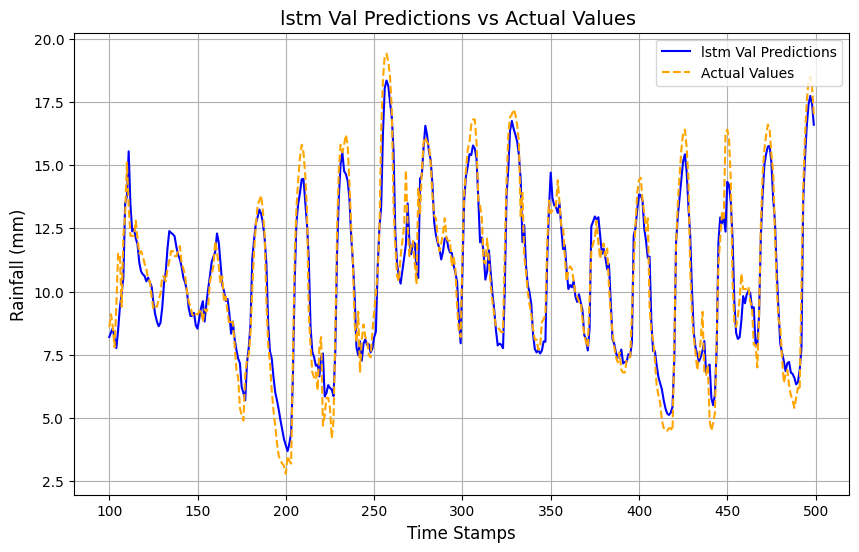

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
       lstm Test Predictions  Actual Values
0                  24.356985           23.8
1                  23.760359           23.4
2                  23.572638           23.5
3                  23.784636           23.4
4                  23.494854           23.4
...                      ...            ...
21912               7.943742            8.4
21913               8.011763            8.4
21914               8.148131            8.4
21915               8.097022            8.9
21916               8.101249            8.1

[21917 rows x 2 columns]


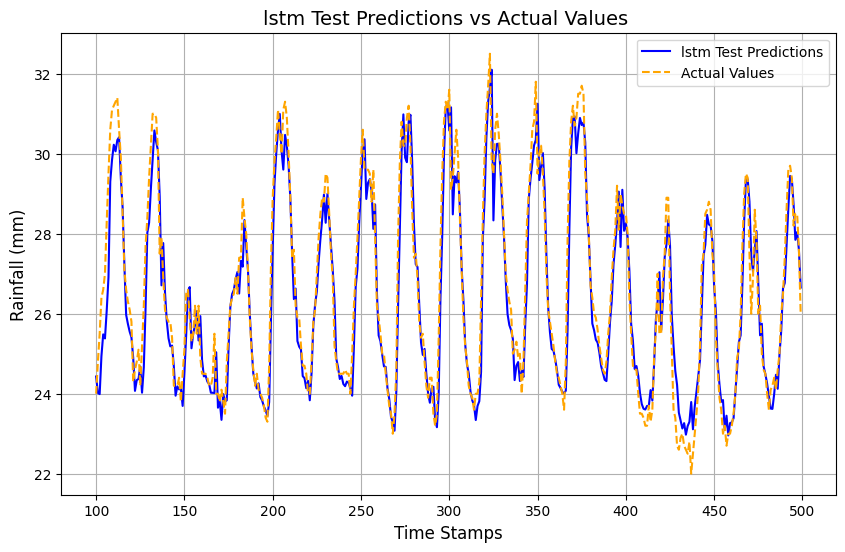


Training GRU model with CUSTOM loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 77s 13ms/step - loss: 93.9510 - mae: 5.1824 - mse: 52.0081 - root_mean_squared_error: 6.7799 - val_loss: 2.5086 - val_mae: 0.9853 - val_mse: 1.6698 - val_root_mean_squared_error: 1.2922 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 16.1536 - mae: 2.4984 - mse: 10.4069 - root_mean_squared_error: 3.2235 - val_loss: 2.1335 - val_mae: 0.8580 - val_mse: 1.3919 - val_root_mean_squared_error: 1.1798 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - loss: 11.0125 - mae: 2.0476 - mse: 7.1477 - root_mean_squared_error: 2.6730 - val_loss: 3.1453 - val_mae: 1.0725 - val_mse: 1.6975 - val_root_mean_squared_error: 1.3029 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 8.4909 - mae: 1.7985 - mse: 5.5457 - root_mean_squared_error: 2.3546 - val_loss: 2.1516 - val_mae: 0.8594 - val_mse: 1.2146 - val_root_mean_squar

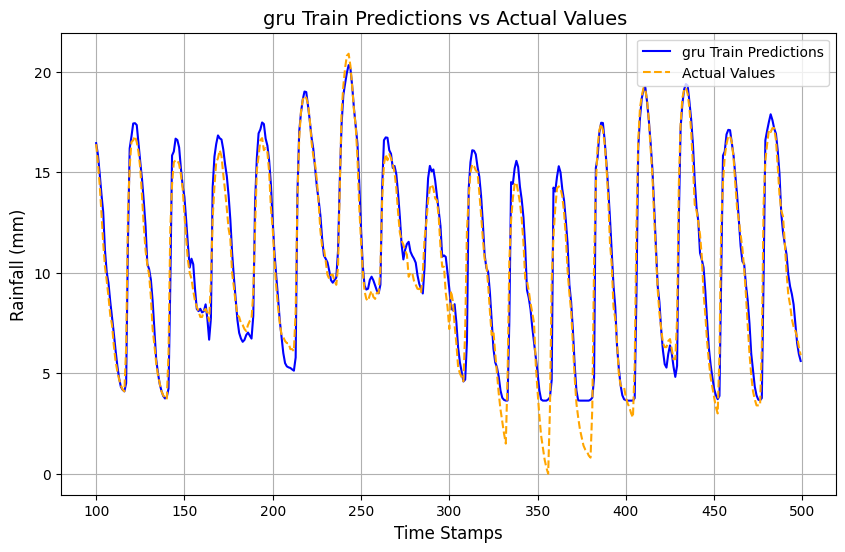

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Val Predictions  Actual Values
0                 9.894650            9.8
1                 9.699072            7.9
2                 7.774133            7.1
3                 5.658944            6.9
4                 5.161128            6.4
...                    ...            ...
21911            26.756399           26.1
21912            25.741415           25.7
21913            25.273252           25.5
21914            24.680462           24.8
21915            24.249357           24.5

[21916 rows x 2 columns]


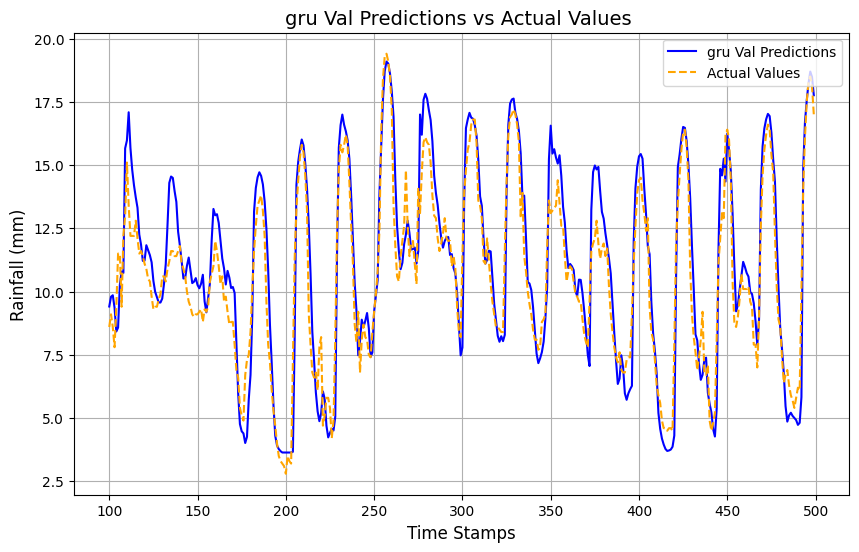

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Test Predictions  Actual Values
0                 23.935015           23.8
1                 22.853899           23.4
2                 22.865223           23.5
3                 23.667475           23.4
4                 23.887512           23.4
...                     ...            ...
21912              7.743238            8.4
21913              7.723525            8.4
21914              8.218061            8.4
21915              8.849006            8.9
21916              8.816343            8.1

[21917 rows x 2 columns]


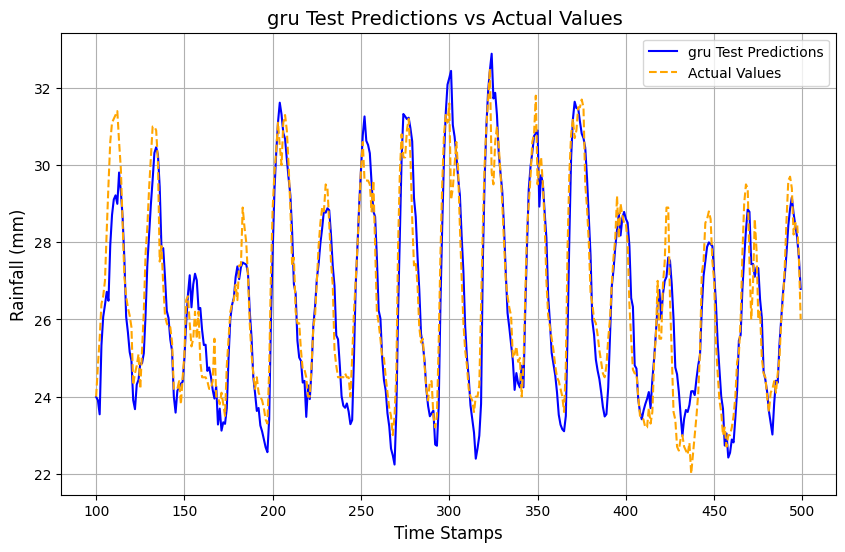

Results for loss function 'custom' saved in '../artifacts/results/custom'.

Model Evaluation Results:

CNN:
mse: 1.2349
mae: 0.8394
false_negative_rate: 0.0000

LSTM:
mse: 0.9360
mae: 0.7327
false_negative_rate: 0.0000

GRU:
mse: 1.5073
mae: 0.8999
false_negative_rate: 0.0000


In [21]:
# Main execution
def main():
    try:
        # Define loss functions to iterate over
        loss_functions = ['mse', 'mae', 'huber', 'weighted_mse', 'custom']
        
        for loss_function in loss_functions:
            # Create a directory for the current loss function
            results_dir = f'../artifacts/results/{loss_function}'
            os.makedirs(results_dir, exist_ok=True)
        
            # Train models
            models = {
                'cnn': create_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2])),
                'lstm': create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2])),
                'gru': create_gru_model(input_shape=(X_train.shape[1], X_train.shape[2])),
            }
            
            results = {}
            for name, model in models.items():
                print(f"\nTraining {name.upper()} model with {loss_function.upper()} loss...")
                
                try:
                    history = train_model(
                        model, X_train, y_train, X_val, y_val,
                        f'../artifacts/models/multivariate/model_{name}_{loss_function}.keras', 
                        epochs=5, loss_function=loss_function, learning_rate=1e-3
                    )
                except Exception as e:
                    print(f"Error training {name.upper()} model: {e}")
                    continue
                
                try:
                    results[name] = evaluate_model(model, X_test, y_test)
                except Exception as e:
                    print(f"Error evaluating {name.upper()} model: {e}")
                    continue
                
                # Save training history to CSV
                history_df = pd.DataFrame(history.history)
                history_df.to_csv(os.path.join(results_dir, f'{name}_history.csv'), index=False)
                
                # Plot training history
                plt.figure(figsize=(10, 6))
                plt.plot(history.history['loss'], label='Training Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title(f'{name.upper()} Model Training History')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(os.path.join(results_dir, f'{name}_training_history.png'))
                plt.close()  # Close the plot to free memory
                
                # Save evaluation results to a text file
                with open(os.path.join(results_dir, f'{name}_evaluation.txt'), 'w') as f:
                    for metric_name, value in results[name].items():
                        f.write(f"{metric_name}: {value:.4f}\n")
                
                # Plot predictions for Train, Val, and Test datasets and save the plots
                    for dataset, data, true_values in zip(['Train', 'Val', 'Test'], 
                                                        [X_train, X_val, X_test], 
                                                        [y_train, y_val, y_test]):
                        plot_predictions(
                            model=model, 
                            X_data=data, 
                            y_data=true_values, 
                            label=name + ' ' + dataset, 
                            start=100, 
                            end=500
                        )
                        plt.savefig(os.path.join(results_dir, f'{name}_{dataset.lower()}_predictions.png'))
                        plt.close()  # Close the plot to free memory
            
            print(f"Results for loss function '{loss_function}' saved in '{results_dir}'.")
        
        return results
    except Exception as e:
        print(f"Error in main: {e}")
        raise

if __name__ == "__main__":
    try:
        results = main()
        print("\nModel Evaluation Results:")
        for model_name, metrics in results.items():
            print(f"\n{model_name.upper()}:")
            for metric_name, value in metrics.items():
                print(f"{metric_name}: {value:.4f}")
    except Exception as e:
        print(f"Unhandled error in execution: {e}")

Q. Workflow didn't irerate for other loss functions, only trained for the custom loss function, why is that??

A. The issue in your main function arises from the placement of the model training and evaluation code inside the loop that iterates over the loss functions. Specifically, the code for training the models and saving results is not nested within the loop that iterates over the loss_functions. As a result, it only executes for the last loss function defined in the loop.

# Metrics Interpretation

1. **Mean Squared Error (MSE):** Lower values indicate better performance, as MSE measures the average squared difference between predicted and actual values.
2. **Mean Absolute Error (MAE):** Similar to MSE, lower values are better. MAE measures the average absolute difference between predicted and actual values.
3. **False Negative Rate (FNR):** A lower false negative rate is better, as it indicates that the model is correctly identifying positive cases. A high FNR means the model is missing many positive cases.

# Model Evaluation Results:

1. **LSTM:** 
* *mse:* 0.5540 
* *mae:* 0.1721 
* *false_negative_rate:* 0.5877

2. **GRU:** 
* *mse:* 0.4852 
* *mae:* 0.1671 
* *false_negative_rate:* 0.4767

3. **CNN:** 
* *mse:* 0.4841 
* *mae:* 0.1733 
* *false_negative_rate:* 0.5009

4. **CNN_2:** 
* *mse:* 1.1112 
* *mae:* 0.8054 
* *false_negative_rate:* 0.0000

## Summary of Model Performance

1. **CNN:** Best *MSE (0.4841)* but relatively high *FNR (0.5009)*.
2. **GRU:** Best *MAE (0.1671)* and a lower* FNR (0.4767)* compared to LSTM and CNN.
3. **LSTM:** Higher MSE and MAE than GRU and CNN, with the highest* FNR (0.5877)*.
4. **CNN_2:** Poor overall performance with the highest *MSE (1.1112)* and *MAE (0.8054)*, despite a perfect *FNR (0.0000)*.

### Conclusion *(Based on the evaluation metrics)*:

* **Best Overall Model:** GRU seems to be the best choice overall, as it has the lowest MAE and a competitive FNR.
* **Best for MSE:** CNN has the lowest MSE, but its FNR is higher than that of the GRU.
* **Best for False Negatives:** CNN_2 has a perfect FNR, but its overall prediction quality is poor.

### Recommendation
If your primary concern is minimizing average prediction error, the GRU is the best choice. If you are particularly concerned about false negatives (e.g., in a medical diagnosis context), you might want to investigate the CNN_2 further, despite its poor overall performance.